In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import re
from tqdm import tqdm #Thư viện để tạo thanh tiến trình trong Python
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences #Đệm các chuỗi để có cùng độ dài
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer #Dùng để mã hóa văn bản
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping #Các hàm callback để lưu mô hình và dừng huấn luyện sớm.
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from scipy.spatial.distance import euclidean
import librosa
tqdm.pandas() #Tích hợp thanh tiến trình tqdm với pandas.
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')

In [ ]:
words = pd.read_csv('/TRAIN/DR1/FCJF0/SA1.WRD',sep=' ',header=None)
phones = pd.read_csv('/TRAIN/DR1/FCJF0/SA1.PHN',sep=' ',header=None)

Xử Lý dữ liệu

- Thu thập và xử lý dữ liệu từ các tệp văn bản và âm vị từ nhiều phương ngữ khác nhau, sau đó ghép nối chúng lại thành một danh sách các DataFrame.
- Sau đó, bạn có thể ghép nối các DataFrame này thành một DataFrame duy nhất để phân tích hoặc sử dụng cho các bước tiếp theo trong quy trình xử lý ngôn ngữ tự nhiên (NLP) hoặc học máy.

In [ ]:
dialects = ['DR1','DR2','DR3'] #Danh sách các phương ngữ cần xử lý.
frames = [] # Danh sách trống để lưu trữ các DataFrame sau khi xử lý từng phương ngữ.
for dialect in dialects:
    print(f"Vùng ngôn ngữ: {dialect}")
    word_paths = glob.glob(f'/content/drive/MyDrive/Colab Notebooks/data_NDĐT/TRAIN/{dialect}/*/*.WRD', recursive = True) #Tìm tất cả các tệp .WRD trong thư mục tương ứng với phương ngữ hiện tại.
    for word_path in tqdm(word_paths):
        speaker_pattern = re.findall("\/[A-Z0-9]+\/[A-Z0-9]+.WRD",word_path)[0].split(".")[0] #Trích xuất thông tin về người nói từ đường dẫn tệp .WRD.
        pattern = re.findall("[A-Z0-9]+.WRD",word_path)[0].split(".")[0] #Trích xuất mẫu tên tệp từ đường dẫn tệp .WRD.
        speaker_path = re.findall(".+\/",word_path)[0] # Trích xuất đường dẫn tới thư mục chứa tệp hiện tại.
        phone_path = os.path.join(speaker_path,pattern+'.PHN') #Tạo đường dẫn tới tệp .PHN tương ứng.
        words = pd.read_csv(word_path,sep=' ',header=None) #Đọc tệp .WRD vào DataFrame.
        phones = pd.read_csv(phone_path,sep=' ',header=None) # Đọc tệp .PHN vào DataFrame.
        words['dialect'] = [dialect]*len(words) # Thêm cột dialect vào DataFrame words.
        words['speaker'] = [speaker_pattern]*len(words) # Thêm cột speaker vào DataFrame words.
        #Gán âm vị cho từng từ
        for index,record in words.iterrows(): #Lặp qua từng dòng trong DataFrame words.
            ph = ' '.join(phones[(phones[0]>=record[0]) & (phones[1]<=record[1])][2].tolist()) #Trích xuất các âm vị tương ứng với khoảng thời gian của từ hiện tại.
            words.loc[index,'phoneme'] = ph #Gán các âm vị cho từ hiện tại.
        frames.append(words) #Thêm DataFrame words đã xử lý vào danh sách frames.

Vùng ngôn ngữ: DR1


100%|██████████| 380/380 [03:13<00:00,  1.97it/s]


Vùng ngôn ngữ: DR2


100%|██████████| 760/760 [06:20<00:00,  2.00it/s]


Vùng ngôn ngữ: DR3


100%|██████████| 760/760 [06:18<00:00,  2.01it/s]


Xuất ra dữ liệu đặc trưng có trong 3 file

In [ ]:
data = pd.concat(frames)
data.reset_index(drop=True,inplace=True)
data.columns = ['start','end','word','dialect','speaker','phoneme']
data

,start,end,word,dialect,speaker,phoneme
0,2280,4900,eat,DR1,/FDML0/SX69,iy q
1,4900,7720,your,DR1,/FDML0/SX69,y er r
2,6308,13994,raisins,DR1,/FDML0/SX69,r ey z en z
3,13994,23000,outdoors,DR1,/FDML0/SX69,q aw tcl d ao r z
4,23000,24875,on,DR1,/FDML0/SX69,ah n
...,...,...,...,...,...,...
16477,19258,20920,an,DR3,/MWDK0/SA2,ix n
16478,20920,25960,oily,DR3,/MWDK0/SA2,oy l ix
16479,25960,30820,rag,DR3,/MWDK0/SA2,r ae gcl g
16480,30820,35300,like,DR3,/MWDK0/SA2,l ay kcl


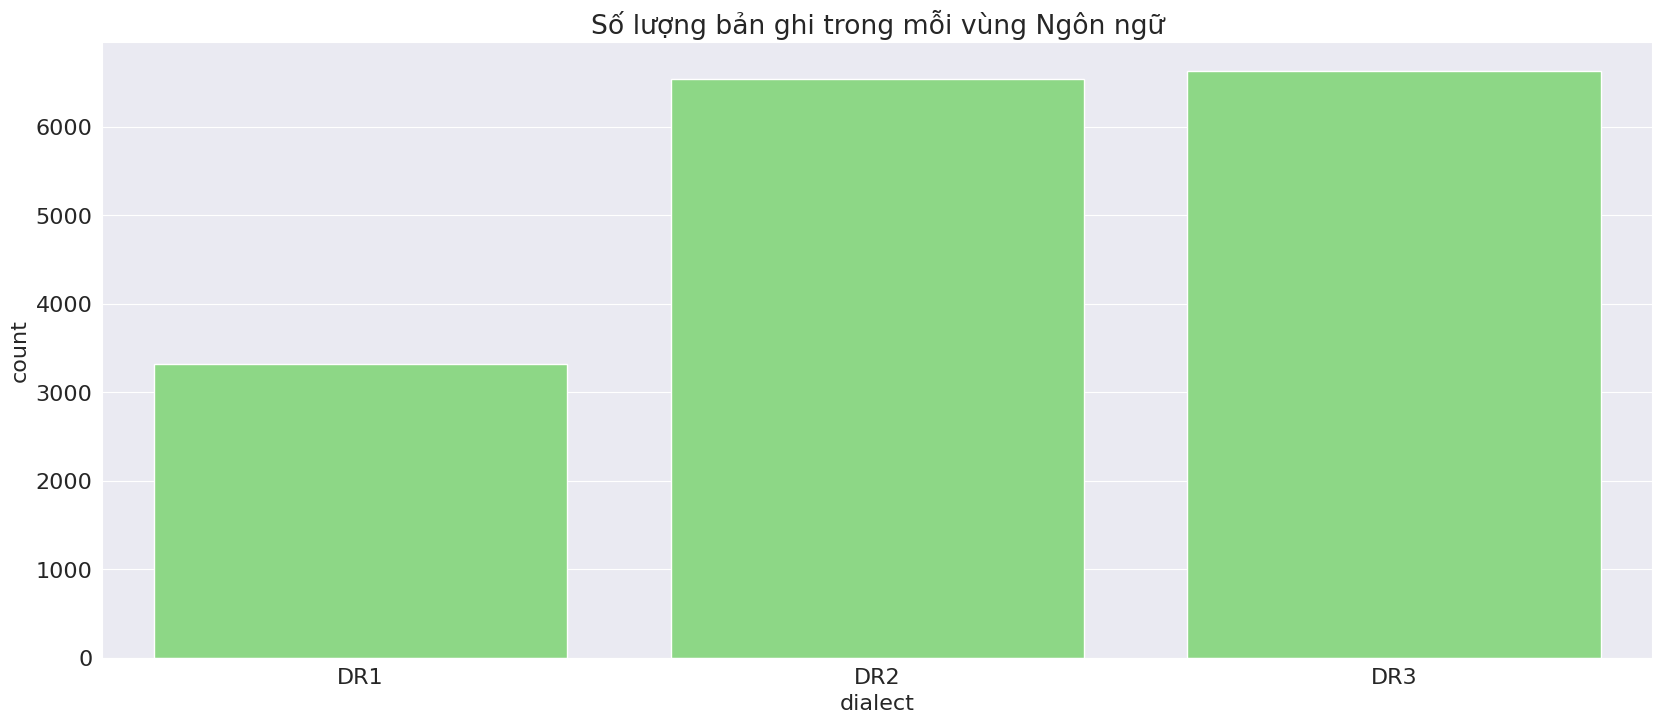

In [ ]:
sns.countplot(data=data,x='dialect',color='#82E578')
plt.title("Số lượng bản ghi trong mỗi vùng Ngôn ngữ")
plt.show()

In [ ]:
data['speaker_name'] = data['speaker'].apply(lambda x: x.split('/')[1])
data['audio_name'] = data['speaker'].apply(lambda x: x.split('/')[2])
data

,start,end,word,dialect,speaker,phoneme,speaker_name,audio_name
0,2280,4900,eat,DR1,/FDML0/SX69,iy q,FDML0,SX69
1,4900,7720,your,DR1,/FDML0/SX69,y er r,FDML0,SX69
2,6308,13994,raisins,DR1,/FDML0/SX69,r ey z en z,FDML0,SX69
3,13994,23000,outdoors,DR1,/FDML0/SX69,q aw tcl d ao r z,FDML0,SX69
4,23000,24875,on,DR1,/FDML0/SX69,ah n,FDML0,SX69
...,...,...,...,...,...,...,...,...
16477,19258,20920,an,DR3,/MWDK0/SA2,ix n,MWDK0,SA2
16478,20920,25960,oily,DR3,/MWDK0/SA2,oy l ix,MWDK0,SA2
16479,25960,30820,rag,DR3,/MWDK0/SA2,r ae gcl g,MWDK0,SA2
16480,30820,35300,like,DR3,/MWDK0/SA2,l ay kcl,MWDK0,SA2


Ở đây chọn DR1 và DR2 làm tập train, DR3 làm tập val

Việc phân chia này thường được thực hiện để đảm bảo rằng tập huấn luyện và tập kiểm tra có các từ khác nhau, điều này giúp đánh giá mô hình trên dữ liệu chưa từng thấy trong quá trình huấn luyện, từ đó cung cấp đánh giá chính xác hơn về khả năng tổng quát hóa của mô hình.


In [ ]:
train_labels = set(data[data['dialect'].isin(['DR1','DR2'])]['word'].tolist())
val_labels = set(data[data['dialect']=='DR3']['word'].tolist())

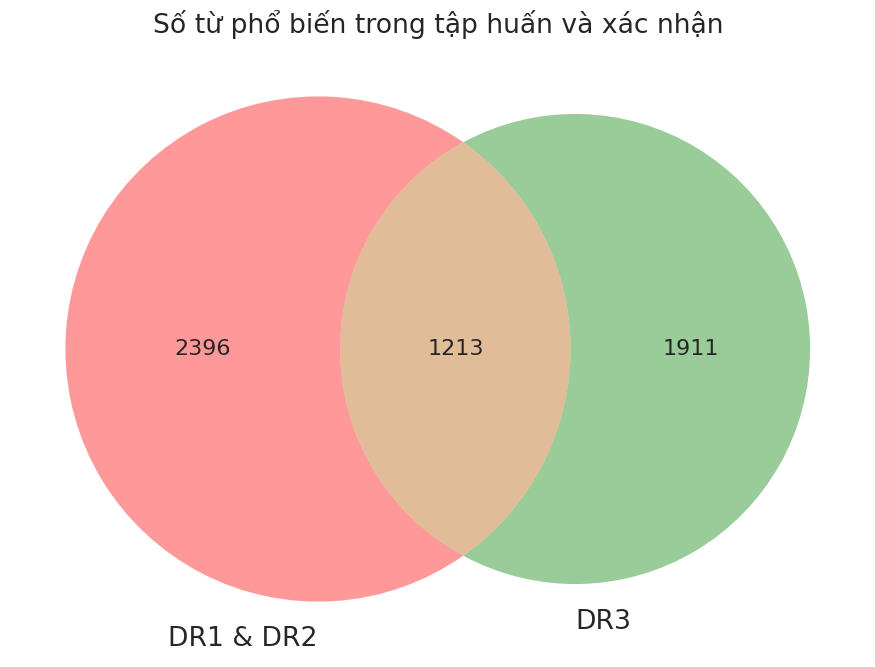

In [ ]:
venn2(subsets = (len(train_labels), len(val_labels), len(train_labels & val_labels)), set_labels = ('DR1 & DR2', 'DR3'))
plt.title("Số từ phổ biến trong tập huấn và xác nhận")
plt.show()

In [ ]:
encoder = LabelEncoder() #dùng để chuyển đổi các nhãn phân loại thành các giá trị số duy nhất.
#fit (tìm hiểu các giá trị duy nhất trong dữ liệu)
#transform (chuyển đổi các giá trị này thành số tương ứng).
data['label'] = encoder.fit_transform(data['word']) #

Phân chia dữ liệu theo phương ngữ và trộn ngẫu nhiên dữ liệu tập huấn luyện là một bước quan trọng trong việc chuẩn bị dữ liệu cho mô hình học máy

Việc trộn ngẫu nhiên dữ liệu giúp ngăn ngừa sự thiên vị có thể xảy ra nếu dữ liệu được sắp xếp theo một thứ tự cụ thể. Điều này đảm bảo rằng mô hình sẽ học được từ dữ liệu phân phối đều và đa dạng.

In [ ]:
#Tạo tập huấn luyện
train = data[data['dialect'].isin(['DR1','DR2'])][['phoneme','word','label']]
#Trộn ngẫu nhiên tập huấn luyện
train = train.sample(frac=1).reset_index(drop=True)
#Tạo tập kiểm tra (validation)
val = data[data['dialect']=='DR3'].reset_index(drop=True)[['phoneme','word','label']]

Chuyển đổi dữ liệu văn bản thành dạng số

In [ ]:
phonemes = data['phoneme'].tolist() #Lấy cột phoneme từ DataFrame data và chuyển đổi nó thành một danh sách các chuỗi
tokenizer = Tokenizer(oov_token='OOV') # các từ không có trong từ điển, giúp mô hình có thể xử lý tốt hơn các từ mới hoặc hiếm gặp trong dữ liệu kiểm tra.
tokenizer.fit_on_texts(phonemes) #Huấn luyện Tokenizer trên danh sách các chuỗi âm vị.
vocab_size = len(tokenizer.word_index) + 1 # nếu từ điển có thì sẽ +1, còn không có thì sẽ thay bằng OOV
print("Vocab Size: ",vocab_size) #In kích thước từ vựng.
print(tokenizer.word_index) # In từ điển từ với các từ và chỉ số số học tương ứng.

Vocab Size:  62
{'OOV': 1, 'ix': 2, 's': 3, 'n': 4, 'iy': 5, 'tcl': 6, 'r': 7, 'l': 8, 'kcl': 9, 'dcl': 10, 'ih': 11, 'k': 12, 't': 13, 'ae': 14, 'ax': 15, 'm': 16, 'eh': 17, 'z': 18, 'd': 19, 'axr': 20, 'w': 21, 'aa': 22, 'dh': 23, 'ao': 24, 'dx': 25, 'pcl': 26, 'p': 27, 'q': 28, 'ay': 29, 'ah': 30, 'gcl': 31, 'ey': 32, 'f': 33, 'sh': 34, 'er': 35, 'ow': 36, 'b': 37, 'g': 38, 'v': 39, 'ux': 40, 'bcl': 41, 'y': 42, 'jh': 43, 'ng': 44, 'hv': 45, 'nx': 46, 'hh': 47, 'el': 48, 'ch': 49, 'oy': 50, 'aw': 51, 'en': 52, 'th': 53, 'uw': 54, 'uh': 55, 'h': 56, 'epi': 57, 'zh': 58, 'em': 59, 'eng': 60, 'pau': 61}


In [ ]:
# Lấy chuỗi âm vị từ dữ liệu huấn luyện và dữ liệu kiểm tra
sequences = train['phoneme'].values

# Chuyển đổi chuỗi âm vị thành chuỗi chỉ số số học
train_sequences = tokenizer.texts_to_sequences(train['phoneme'].values)
val_sequences = tokenizer.texts_to_sequences(val['phoneme'].values)

# Tính toán độ dài tối đa của các chuỗi âm vị
max_length = len(max(sequences, key=len))

# In ra độ dài tối đa
print(max_length)

46


Chuẩn bị đầu vào cho mô hình: Các chuỗi chỉ số số học đã được chuyển đổi thành các chuỗi có độ dài cố định bằng cách thêm hoặc cắt bớt các phần tử, điều này là cần thiết cho việc đưa dữ liệu vào mô hình học máy.

Chuẩn bị nhãn: Nhãn của các mẫu cũng đã được chuẩn bị để sử dụng trong việc huấn luyện và kiểm tra mô hình.

In [ ]:
# Chuyển đổi chuỗi chỉ số số học thành các chuỗi có độ dài cố định
X_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_val = pad_sequences(val_sequences, maxlen=max_length, padding='post')

# Chuẩn bị nhãn cho tập huấn luyện và tập kiểm tra
y_train = train['label'].values
y_val = val['label'].values

Xây dựng mô hình LSTM

In [ ]:
embedding_dim = 10
n_words = data['label'].nunique()

model = Sequential([Embedding(vocab_size, embedding_dim, input_length=max_length),
                    Bidirectional(LSTM(50)),
                    Dense(8, activation='relu'),
                    Dense(n_words, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 10)            620       
                                                                 
 bidirectional (Bidirection  (None, 100)               24400     
 al)                                                             
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
 dense_1 (Dense)             (None, 3094)              27846     
                                                                 
Total params: 53674 (209.66 KB)
Trainable params: 53674 (209.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Huấn luyện mô hình

In [ ]:
history = model.fit(X_train,y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val,y_val),
                    validation_batch_size=32)

Epoch 1/50
308/308 [==============================] - 11s 19ms/step - loss: 6.8938 - val_loss: 6.3783
Epoch 2/50
308/308 [==============================] - 3s 11ms/step - loss: 6.0401 - val_loss: 6.1914
Epoch 3/50
308/308 [==============================] - 4s 13ms/step - loss: 5.8654 - val_loss: 6.0988
Epoch 4/50
308/308 [==============================] - 3s 10ms/step - loss: 5.7053 - val_loss: 6.0054
Epoch 5/50
308/308 [==============================] - 3s 10ms/step - loss: 5.5708 - val_loss: 5.9215
Epoch 6/50
308/308 [==============================] - 3s 10ms/step - loss: 5.4652 - val_loss: 5.8368
Epoch 7/50
308/308 [==============================] - 4s 13ms/step - loss: 5.3600 - val_loss: 5.8445
Epoch 8/50
308/308 [==============================] - 3s 10ms/step - loss: 5.2577 - val_loss: 5.8478
Epoch 9/50
308/308 [==============================] - 3s 10ms/step - loss: 5.1610 - val_loss: 5.8222
Epoch 10/50
308/308 [==============================] - 3s 10ms/step - loss: 5.0695 - val_l

In [ ]:
# Đánh giá hiệu suất của mô hình trên tập kiểm tra
model.evaluate(X_val,y_val)

208/208 [==============================] - 1s 4ms/step - loss: 7.9203


7.920278549194336

Đoạn mã này giúp tạo ra một danh sách các bản ghi cho mỗi người nói trong dữ liệu, trong đó mỗi bản ghi bao gồm thông tin về câu nói và chuỗi âm vị của họ.

In [ ]:
#tạo ra một danh sách các bản ghi (records) từ dữ liệu ban đầu
records = []
#Duyệt qua mỗi người nói và tạo các bản ghi
for speaker in tqdm(data['speaker'].unique()):
  #Tạo câu nói và chuỗi âm vị cho mỗi người nói
    sentence = " ".join(data[data['speaker']==speaker]['word'].tolist())
    phoneme = "  ".join(data[data['speaker']==speaker]['phoneme'].tolist())
    #Thêm thông tin của mỗi người nói vào danh sách records
    records.append([speaker,sentence,phoneme])

100%|██████████| 1900/1900 [00:07<00:00, 242.61it/s]


In [ ]:
df = pd.DataFrame(records,columns=['speaker','sentence','phonemes'])
df.head()

,speaker,sentence,phonemes
0,/FDML0/SX69,eat your raisins outdoors on the porch steps,iy q y er r r ey z en z q aw tcl d ao r z ...
1,/FDML0/SA2,don't ask me to carry an oily rag like that,dcl d ow n ae s m iy dx ix kcl k ae r iy ...
2,/FDML0/SA1,she had your dark suit in greasy wash water al...,sh iy hv ae dcl d y er dcl d aa r kcl k s ...
3,/FDML0/SI1149,the response of reaction is dominated by a con...,dh ix r iy s pcl p aa n tcl s ix r iy ae kc...
4,/FDML0/SX339,did shawn catch that big goose without help,dcl d ih dcl sh ao n kcl k ae tcl ch dh ah ...


Hàm này nhận đầu vào là một câu văn được biểu diễn dưới dạng chuỗi âm vị, và trả về câu văn được dự đoán tương ứng là các từ.



In [ ]:
def predict_words(sentence):
    phonemes = sentence.split("  ")
    word_sentence = ""
    for x in phonemes:
        text_seq = tokenizer.texts_to_sequences([x])
        text_padded = pad_sequences(text_seq, maxlen=max_length, padding='post')
        pred = model.predict(text_padded)
        pred = np.argmax(pred,axis=1)
        word = encoder.classes_[pred[0]]
        word_sentence = word_sentence + word + " "
    word_sentence = word_sentence.strip()
    return word_sentence

Dòng mã này giúp dự đoán các câu văn tương ứng với mỗi chuỗi âm vị trong DataFrame df bằng cách sử dụng hàm predict_words, sau đó lưu kết quả vào một cột mới trong DataFrame

In [ ]:
## Áp dụng hàm predict_words cho mỗi dòng trong cột 'phonemes'
df['sentence_predictions'] = df['phonemes'].progress_apply(predict_words)

  0%|          | 0/1900 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/1900 [00:01<17:55,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/1900 [00:01<18:14,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 4/1900 [00:02<19:17,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 5/1900 [00:03<20:55,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 6/1900 [00:03<18:53,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 7/1900 [00:04<17:05,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 8/1900 [00:04<16:13,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 9/1900 [00:04<15:18,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 10/1900 [00:05<13:23,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 11/1900 [00:05<14:26,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 12/1900 [00:06<19:05,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 13/1900 [00:07<17:17,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 14/1900 [00:07<14:50,  2.12it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 15/1900 [00:08<18:27,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 16/1900 [00:08<18:20,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 17/1900 [00:09<17:03,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 18/1900 [00:10<22:53,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 19/1900 [00:10<19:46,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 20/1900 [00:11<17:51,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 21/1900 [00:11<18:37,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 22/1900 [00:12<19:36,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 23/1900 [00:12<17:03,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 24/1900 [00:13<17:18,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 25/1900 [00:14<20:54,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 26/1900 [00:14<17:30,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 27/1900 [00:15<14:58,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 28/1900 [00:15<13:09,  2.37it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 29/1900 [00:16<15:16,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 30/1900 [00:16<16:46,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 31/1900 [00:17<16:54,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 32/1900 [00:17<16:07,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 33/1900 [00:18<15:11,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 34/1900 [00:18<13:57,  2.23it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 35/1900 [00:19<18:52,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 36/1900 [00:20<18:50,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 37/1900 [00:20<21:12,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 38/1900 [00:21<19:50,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 39/1900 [00:22<23:07,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 40/1900 [00:23<24:14,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 41/1900 [00:23<21:56,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 42/1900 [00:24<24:29,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 43/1900 [00:25<20:28,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 44/1900 [00:25<18:12,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 45/1900 [00:26<20:01,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 46/1900 [00:26<17:48,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 47/1900 [00:27<15:18,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 48/1900 [00:27<16:39,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 49/1900 [00:28<17:16,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 50/1900 [00:29<18:06,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 51/1900 [00:29<18:49,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 52/1900 [00:30<18:42,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 53/1900 [00:30<19:05,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 54/1900 [00:31<18:20,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 55/1900 [00:31<15:31,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 56/1900 [00:32<15:25,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 57/1900 [00:32<14:38,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 58/1900 [00:33<14:06,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 59/1900 [00:33<13:09,  2.33it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 60/1900 [00:34<15:18,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 61/1900 [00:34<18:19,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 62/1900 [00:35<18:32,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 63/1900 [00:36<22:35,  1.35it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 64/1900 [00:37<23:52,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 65/1900 [00:38<22:12,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 66/1900 [00:38<23:42,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 67/1900 [00:39<20:49,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 68/1900 [00:39<18:33,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 69/1900 [00:40<19:14,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 70/1900 [00:40<15:45,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 71/1900 [00:41<16:59,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 72/1900 [00:42<19:01,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 73/1900 [00:43<20:59,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 74/1900 [00:43<20:49,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 75/1900 [00:43<16:44,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 76/1900 [00:44<15:33,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 77/1900 [00:44<13:44,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 78/1900 [00:45<14:04,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 79/1900 [00:45<13:16,  2.29it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 80/1900 [00:46<14:49,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 81/1900 [00:46<15:53,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 82/1900 [00:47<17:05,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 83/1900 [00:47<15:15,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 84/1900 [00:48<19:53,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 85/1900 [00:49<21:41,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 86/1900 [00:50<22:08,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 87/1900 [00:51<23:32,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 88/1900 [00:51<21:20,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 89/1900 [00:52<21:04,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 90/1900 [00:52<17:32,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 91/1900 [00:53<18:11,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 92/1900 [00:54<18:46,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 93/1900 [00:54<16:24,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 94/1900 [00:55<15:20,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 95/1900 [00:55<19:33,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 96/1900 [00:56<17:07,  1.76it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 97/1900 [00:57<18:19,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 98/1900 [00:57<15:57,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 99/1900 [00:57<16:07,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 100/1900 [00:58<17:05,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 101/1900 [00:59<17:03,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 102/1900 [00:59<17:59,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 103/1900 [01:00<16:23,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 104/1900 [01:00<16:16,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 105/1900 [01:01<15:48,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 106/1900 [01:01<15:23,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 107/1900 [01:02<15:07,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 108/1900 [01:03<18:52,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 109/1900 [01:03<19:26,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 110/1900 [01:04<20:03,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 111/1900 [01:05<21:57,  1.36it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 112/1900 [01:06<21:44,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 113/1900 [01:06<18:35,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 114/1900 [01:07<18:02,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 115/1900 [01:07<16:24,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 116/1900 [01:08<17:24,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 117/1900 [01:08<18:45,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 118/1900 [01:09<14:45,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 119/1900 [01:09<15:10,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 120/1900 [01:10<16:45,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 121/1900 [01:11<17:06,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 122/1900 [01:11<17:26,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 123/1900 [01:12<18:02,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 124/1900 [01:12<15:19,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 125/1900 [01:12<13:29,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 126/1900 [01:13<15:19,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 127/1900 [01:14<16:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 128/1900 [01:14<16:01,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 129/1900 [01:15<14:55,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 130/1900 [01:15<14:15,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 131/1900 [01:16<15:52,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 132/1900 [01:16<16:36,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 133/1900 [01:17<19:32,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 134/1900 [01:18<22:14,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 135/1900 [01:19<20:23,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 136/1900 [01:19<20:35,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 137/1900 [01:20<18:50,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 138/1900 [01:21<18:35,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 139/1900 [01:21<16:09,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 140/1900 [01:22<16:09,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 141/1900 [01:22<15:02,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 142/1900 [01:22<14:52,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 143/1900 [01:23<14:15,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 144/1900 [01:23<14:18,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 145/1900 [01:24<16:56,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 146/1900 [01:24<14:37,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 147/1900 [01:25<14:24,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 148/1900 [01:26<15:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 149/1900 [01:26<16:54,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 150/1900 [01:27<15:40,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 151/1900 [01:27<17:30,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 152/1900 [01:28<17:40,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 153/1900 [01:29<18:08,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 154/1900 [01:29<19:10,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 155/1900 [01:30<19:18,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 156/1900 [01:31<21:03,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 157/1900 [01:32<22:22,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 158/1900 [01:33<21:06,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 159/1900 [01:33<18:42,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 160/1900 [01:34<18:53,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 161/1900 [01:34<18:17,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 162/1900 [01:35<18:27,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 163/1900 [01:35<16:38,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 164/1900 [01:36<15:29,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 165/1900 [01:36<16:42,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 166/1900 [01:37<13:17,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 167/1900 [01:37<14:38,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 168/1900 [01:38<15:13,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 169/1900 [01:38<13:47,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 170/1900 [01:39<15:29,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 171/1900 [01:39<14:47,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 172/1900 [01:40<15:36,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 173/1900 [01:40<14:37,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 174/1900 [01:41<16:03,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 175/1900 [01:42<17:16,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 176/1900 [01:42<16:53,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 177/1900 [01:43<16:35,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 178/1900 [01:43<14:21,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 179/1900 [01:44<21:42,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 180/1900 [01:45<19:54,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 181/1900 [01:46<18:34,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 182/1900 [01:46<19:31,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 183/1900 [01:47<19:10,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 184/1900 [01:47<16:48,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 185/1900 [01:48<15:03,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 186/1900 [01:48<14:29,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 187/1900 [01:49<18:12,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 188/1900 [01:50<19:12,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 189/1900 [01:51<18:53,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 190/1900 [01:51<19:08,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 191/1900 [01:52<17:12,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 192/1900 [01:52<17:56,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 193/1900 [01:53<17:21,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 194/1900 [01:54<17:31,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 195/1900 [01:54<18:13,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 196/1900 [01:55<20:44,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 197/1900 [01:56<19:52,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 198/1900 [01:56<19:17,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 199/1900 [01:57<16:10,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 200/1900 [01:57<13:52,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 201/1900 [01:58<16:00,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 202/1900 [01:59<19:51,  1.43it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 203/1900 [02:00<21:42,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 204/1900 [02:01<24:53,  1.14it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 205/1900 [02:01<21:10,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 206/1900 [02:02<18:04,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 207/1900 [02:02<18:30,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 208/1900 [02:03<16:46,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 209/1900 [02:03<16:28,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 210/1900 [02:04<16:56,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 211/1900 [02:05<15:16,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 212/1900 [02:05<14:24,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 213/1900 [02:05<12:43,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 214/1900 [02:06<12:07,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 215/1900 [02:06<13:45,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 216/1900 [02:07<14:56,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 217/1900 [02:08<16:20,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 218/1900 [02:08<17:17,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 219/1900 [02:09<19:08,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 220/1900 [02:09<16:20,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 221/1900 [02:10<17:28,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 222/1900 [02:11<15:56,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 223/1900 [02:11<14:07,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 224/1900 [02:12<14:25,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 225/1900 [02:13<19:52,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 226/1900 [02:13<19:08,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 227/1900 [02:14<21:50,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 228/1900 [02:15<21:01,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 229/1900 [02:16<19:14,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 230/1900 [02:16<18:59,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 231/1900 [02:17<21:12,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 232/1900 [02:18<19:29,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 233/1900 [02:18<17:55,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 234/1900 [02:19<17:43,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 235/1900 [02:19<15:36,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 236/1900 [02:20<14:13,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 237/1900 [02:20<14:51,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 238/1900 [02:21<14:01,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 239/1900 [02:21<11:56,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 240/1900 [02:22<14:36,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 241/1900 [02:22<16:03,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 242/1900 [02:23<15:19,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 243/1900 [02:24<15:55,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 244/1900 [02:24<12:41,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 245/1900 [02:25<16:38,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 246/1900 [02:26<18:51,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 247/1900 [02:26<16:59,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 248/1900 [02:27<19:59,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 249/1900 [02:28<20:03,  1.37it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 250/1900 [02:28<20:07,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 251/1900 [02:29<22:22,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 252/1900 [02:30<17:45,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 253/1900 [02:30<18:14,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 254/1900 [02:31<17:26,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 255/1900 [02:32<17:31,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 256/1900 [02:32<14:49,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 257/1900 [02:33<15:37,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 258/1900 [02:33<16:12,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 259/1900 [02:34<15:00,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 260/1900 [02:34<14:10,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 261/1900 [02:35<19:13,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 262/1900 [02:36<18:37,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 263/1900 [02:36<16:09,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 264/1900 [02:37<14:55,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 265/1900 [02:37<13:00,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 266/1900 [02:38<13:15,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 267/1900 [02:38<13:55,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 268/1900 [02:39<13:25,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 269/1900 [02:39<16:40,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 270/1900 [02:40<19:57,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 271/1900 [02:41<20:46,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 272/1900 [02:42<23:03,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 273/1900 [02:43<22:17,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 274/1900 [02:43<18:09,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 275/1900 [02:44<17:50,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 276/1900 [02:44<14:32,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 277/1900 [02:45<14:13,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 278/1900 [02:45<15:06,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 279/1900 [02:46<14:16,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 280/1900 [02:47<15:35,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 281/1900 [02:47<14:32,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 282/1900 [02:47<13:16,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 283/1900 [02:48<14:29,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 284/1900 [02:48<11:41,  2.30it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 285/1900 [02:49<11:43,  2.30it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 286/1900 [02:49<11:27,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 287/1900 [02:50<13:03,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 288/1900 [02:50<14:49,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 289/1900 [02:51<16:29,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 290/1900 [02:52<16:35,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 291/1900 [02:52<15:48,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 292/1900 [02:53<17:46,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 293/1900 [02:54<16:36,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 294/1900 [02:55<22:37,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 295/1900 [02:56<22:01,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 296/1900 [02:57<20:43,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 297/1900 [02:57<17:51,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 298/1900 [02:58<17:34,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 299/1900 [02:58<15:22,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 300/1900 [02:59<15:52,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 301/1900 [02:59<16:07,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 302/1900 [03:00<16:51,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 303/1900 [03:00<14:18,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 304/1900 [03:01<16:06,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 305/1900 [03:01<14:50,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 306/1900 [03:02<13:55,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 307/1900 [03:03<15:31,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 308/1900 [03:03<15:50,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 309/1900 [03:04<16:41,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 310/1900 [03:04<14:13,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 311/1900 [03:05<14:43,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 312/1900 [03:05<14:24,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 313/1900 [03:06<13:07,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 314/1900 [03:07<15:17,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 315/1900 [03:07<15:23,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 316/1900 [03:08<18:57,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 317/1900 [03:09<20:11,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 318/1900 [03:10<22:22,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 319/1900 [03:11<21:22,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 320/1900 [03:11<18:29,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 321/1900 [03:12<15:56,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 322/1900 [03:12<15:44,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 323/1900 [03:13<14:07,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 324/1900 [03:13<12:55,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 325/1900 [03:14<14:08,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 326/1900 [03:15<18:01,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 327/1900 [03:15<17:19,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 328/1900 [03:16<15:45,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 329/1900 [03:16<14:44,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 330/1900 [03:17<15:58,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 331/1900 [03:18<16:52,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 332/1900 [03:18<15:53,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 333/1900 [03:19<13:41,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 334/1900 [03:19<14:46,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 335/1900 [03:20<16:01,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 336/1900 [03:20<14:18,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 337/1900 [03:21<17:05,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 338/1900 [03:22<17:05,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 339/1900 [03:23<18:18,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 340/1900 [03:23<17:07,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 341/1900 [03:24<19:30,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 342/1900 [03:25<20:07,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 343/1900 [03:26<19:08,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 344/1900 [03:26<18:59,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 345/1900 [03:27<18:47,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 346/1900 [03:27<14:48,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 347/1900 [03:28<12:50,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 348/1900 [03:28<13:02,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 349/1900 [03:29<14:20,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 350/1900 [03:29<14:12,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 351/1900 [03:30<13:53,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 352/1900 [03:30<12:54,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 353/1900 [03:31<14:05,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 354/1900 [03:31<12:59,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 355/1900 [03:32<13:05,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 356/1900 [03:33<14:20,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 357/1900 [03:33<13:04,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 358/1900 [03:33<12:50,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 359/1900 [03:34<16:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 360/1900 [03:35<17:11,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 361/1900 [03:36<20:04,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 362/1900 [03:37<19:37,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 363/1900 [03:38<18:42,  1.37it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 364/1900 [03:38<19:07,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 365/1900 [03:39<19:54,  1.29it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 366/1900 [03:40<19:25,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 367/1900 [03:41<20:30,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 368/1900 [03:41<18:25,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 369/1900 [03:42<16:27,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 370/1900 [03:42<15:26,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 371/1900 [03:43<15:53,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 372/1900 [03:44<16:05,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 373/1900 [03:45<20:28,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 374/1900 [03:45<17:13,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 375/1900 [03:45<14:03,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 376/1900 [03:46<12:26,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 377/1900 [03:47<15:07,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 378/1900 [03:47<13:03,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 379/1900 [03:48<14:01,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 380/1900 [03:48<16:22,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 381/1900 [03:49<18:22,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 382/1900 [03:50<17:41,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 383/1900 [03:51<19:16,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 384/1900 [03:52<19:44,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 385/1900 [03:53<20:19,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 386/1900 [03:53<17:47,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 387/1900 [03:54<17:50,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 388/1900 [03:54<16:36,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 389/1900 [03:55<15:30,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 390/1900 [03:56<17:43,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 391/1900 [03:57<17:48,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 392/1900 [03:57<17:27,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 393/1900 [03:58<14:43,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 394/1900 [03:58<12:48,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 395/1900 [03:59<14:26,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 396/1900 [03:59<15:34,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 397/1900 [04:00<13:46,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 398/1900 [04:00<14:06,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 399/1900 [04:01<13:18,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 400/1900 [04:02<16:10,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 401/1900 [04:02<16:14,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 402/1900 [04:03<16:41,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 403/1900 [04:04<17:08,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 404/1900 [04:04<15:30,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 405/1900 [04:05<20:06,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 406/1900 [04:06<18:18,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 407/1900 [04:07<17:37,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 408/1900 [04:07<16:35,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 409/1900 [04:08<17:06,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 410/1900 [04:08<14:30,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 411/1900 [04:09<15:09,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 412/1900 [04:10<15:35,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 413/1900 [04:10<16:21,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 414/1900 [04:11<15:06,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 415/1900 [04:11<14:11,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 416/1900 [04:12<13:26,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 417/1900 [04:12<11:25,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 418/1900 [04:13<10:54,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 419/1900 [04:13<11:03,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 420/1900 [04:14<14:24,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 421/1900 [04:15<15:49,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 422/1900 [04:15<13:28,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 423/1900 [04:15<12:25,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 424/1900 [04:16<13:35,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 425/1900 [04:17<14:43,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 426/1900 [04:17<12:10,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 427/1900 [04:17<11:45,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 428/1900 [04:18<13:02,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 429/1900 [04:19<15:52,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 430/1900 [04:20<15:34,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 431/1900 [04:21<17:33,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 432/1900 [04:22<19:53,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 433/1900 [04:22<18:36,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 434/1900 [04:23<16:18,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 435/1900 [04:23<15:03,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 436/1900 [04:24<17:37,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 437/1900 [04:25<16:08,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 438/1900 [04:25<16:02,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 439/1900 [04:26<15:03,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 440/1900 [04:26<14:56,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 441/1900 [04:27<13:44,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 442/1900 [04:28<14:56,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 443/1900 [04:28<15:16,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 444/1900 [04:29<13:31,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 445/1900 [04:29<12:49,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 446/1900 [04:30<15:26,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 447/1900 [04:30<13:44,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 448/1900 [04:31<14:17,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 449/1900 [04:32<14:17,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 450/1900 [04:32<14:43,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 451/1900 [04:33<17:43,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 452/1900 [04:34<18:11,  1.33it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 453/1900 [04:35<16:05,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 454/1900 [04:36<18:28,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 455/1900 [04:36<17:38,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 456/1900 [04:37<17:04,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 457/1900 [04:37<14:49,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 458/1900 [04:38<15:33,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 459/1900 [04:39<16:39,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 460/1900 [04:40<17:49,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 461/1900 [04:40<15:45,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 462/1900 [04:41<14:01,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 463/1900 [04:41<14:57,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 464/1900 [04:42<15:16,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 465/1900 [04:43<15:56,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 466/1900 [04:44<17:44,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 467/1900 [04:44<16:35,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 468/1900 [04:45<13:55,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 469/1900 [04:45<12:37,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 470/1900 [04:45<11:32,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 471/1900 [04:46<14:16,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 472/1900 [04:47<12:50,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 473/1900 [04:48<16:00,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 474/1900 [04:48<16:41,  1.42it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 475/1900 [04:49<18:22,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 476/1900 [04:50<17:15,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 477/1900 [04:51<17:46,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 478/1900 [04:51<14:30,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 479/1900 [04:52<16:07,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 480/1900 [04:52<15:12,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 481/1900 [04:53<15:56,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 482/1900 [04:54<15:21,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 483/1900 [04:54<12:45,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 484/1900 [04:54<10:53,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 485/1900 [04:55<12:29,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 486/1900 [04:55<11:12,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 487/1900 [04:56<12:38,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 488/1900 [04:57<12:41,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 489/1900 [04:57<14:16,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 490/1900 [04:58<16:06,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 491/1900 [04:59<14:40,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 492/1900 [04:59<15:59,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 493/1900 [05:00<13:39,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 494/1900 [05:01<15:00,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 495/1900 [05:01<13:53,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 496/1900 [05:02<17:02,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 497/1900 [05:03<17:46,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 498/1900 [05:03<15:54,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 499/1900 [05:04<16:45,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 500/1900 [05:05<18:06,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 501/1900 [05:06<15:44,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 502/1900 [05:06<16:10,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 503/1900 [05:07<15:06,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 504/1900 [05:08<15:21,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 505/1900 [05:08<13:59,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 506/1900 [05:09<13:09,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 507/1900 [05:09<14:22,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 508/1900 [05:10<13:26,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 509/1900 [05:10<13:09,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 510/1900 [05:11<11:07,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 511/1900 [05:11<13:18,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 512/1900 [05:12<12:11,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 513/1900 [05:13<13:39,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 514/1900 [05:13<13:24,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 515/1900 [05:14<14:01,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 516/1900 [05:14<12:37,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 517/1900 [05:15<12:32,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 518/1900 [05:16<14:25,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 519/1900 [05:16<15:31,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 520/1900 [05:17<14:39,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 521/1900 [05:17<14:06,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 522/1900 [05:18<16:37,  1.38it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 523/1900 [05:19<18:32,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 524/1900 [05:20<15:25,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 525/1900 [05:20<14:06,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 526/1900 [05:21<14:03,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 527/1900 [05:21<12:34,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 528/1900 [05:22<13:52,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 529/1900 [05:22<12:28,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 530/1900 [05:23<12:49,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 531/1900 [05:24<14:54,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 532/1900 [05:25<15:21,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 533/1900 [05:25<15:44,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 534/1900 [05:26<16:05,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 535/1900 [05:27<14:49,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 536/1900 [05:27<13:04,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 537/1900 [05:27<11:55,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 538/1900 [05:28<11:03,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 539/1900 [05:28<12:26,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 540/1900 [05:29<13:16,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 541/1900 [05:30<12:50,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 542/1900 [05:30<12:40,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 543/1900 [05:31<13:16,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 544/1900 [05:32<15:25,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 545/1900 [05:32<14:23,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 546/1900 [05:33<15:54,  1.42it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 547/1900 [05:34<17:34,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 548/1900 [05:35<16:32,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 549/1900 [05:36<17:46,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 550/1900 [05:36<17:24,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 551/1900 [05:37<16:34,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 552/1900 [05:38<16:33,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 553/1900 [05:38<14:45,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 554/1900 [05:39<12:40,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 555/1900 [05:39<14:20,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 556/1900 [05:40<14:31,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 557/1900 [05:40<12:23,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 558/1900 [05:41<10:33,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 559/1900 [05:41<12:32,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 560/1900 [05:42<11:39,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 561/1900 [05:42<10:52,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 562/1900 [05:43<12:35,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 563/1900 [05:44<14:16,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 564/1900 [05:44<13:39,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 565/1900 [05:45<13:19,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 566/1900 [05:46<13:02,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 567/1900 [05:46<15:30,  1.43it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 568/1900 [05:47<15:33,  1.43it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 569/1900 [05:48<16:42,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 570/1900 [05:49<15:02,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 571/1900 [05:49<15:09,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 572/1900 [05:50<15:04,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 573/1900 [05:51<15:26,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 574/1900 [05:51<14:24,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 575/1900 [05:52<12:45,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 576/1900 [05:52<13:26,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 577/1900 [05:53<14:19,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 578/1900 [05:54<13:58,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 579/1900 [05:54<12:07,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 580/1900 [05:55<12:53,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 581/1900 [05:55<14:21,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 582/1900 [05:56<13:06,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 583/1900 [05:56<11:28,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 584/1900 [05:57<11:28,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 585/1900 [05:58<12:34,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 586/1900 [05:58<12:17,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 587/1900 [05:59<15:55,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 588/1900 [06:00<18:09,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 589/1900 [06:01<16:05,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 590/1900 [06:02<20:42,  1.05it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 591/1900 [06:03<18:10,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 592/1900 [06:03<14:29,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 593/1900 [06:04<14:59,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 594/1900 [06:04<14:03,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 595/1900 [06:05<12:55,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 596/1900 [06:05<12:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 597/1900 [06:06<12:15,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 598/1900 [06:07<12:58,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 599/1900 [06:07<14:48,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 600/1900 [06:08<14:13,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 601/1900 [06:08<12:44,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 602/1900 [06:09<12:47,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 603/1900 [06:09<11:39,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 604/1900 [06:10<11:17,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 605/1900 [06:10<11:27,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 606/1900 [06:11<12:17,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 607/1900 [06:12<14:10,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 608/1900 [06:13<14:00,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 609/1900 [06:13<14:48,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 610/1900 [06:14<12:46,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 611/1900 [06:15<15:31,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 612/1900 [06:15<15:00,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 613/1900 [06:16<16:42,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 614/1900 [06:17<16:29,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 615/1900 [06:18<15:24,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 616/1900 [06:18<13:01,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 617/1900 [06:19<13:52,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 618/1900 [06:19<12:44,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 619/1900 [06:20<11:28,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 620/1900 [06:20<12:24,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 621/1900 [06:22<16:41,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 622/1900 [06:22<15:27,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 623/1900 [06:23<14:23,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 624/1900 [06:24<17:00,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 625/1900 [06:25<16:03,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 626/1900 [06:25<15:45,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 627/1900 [06:26<16:00,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 628/1900 [06:26<13:32,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 629/1900 [06:27<11:47,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 630/1900 [06:27<12:33,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 631/1900 [06:28<14:07,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 632/1900 [06:29<14:58,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 633/1900 [06:30<15:40,  1.35it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 634/1900 [06:31<17:17,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 635/1900 [06:32<18:29,  1.14it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 636/1900 [06:32<16:03,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 637/1900 [06:33<15:59,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 638/1900 [06:34<15:09,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 639/1900 [06:34<13:41,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 640/1900 [06:35<16:19,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 641/1900 [06:36<15:07,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 642/1900 [06:37<14:37,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 643/1900 [06:37<11:58,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 644/1900 [06:38<15:23,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 645/1900 [06:39<14:23,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 646/1900 [06:39<15:14,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 647/1900 [06:40<14:12,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 648/1900 [06:41<14:43,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 649/1900 [06:41<11:44,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 650/1900 [06:42<12:48,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 651/1900 [06:42<12:26,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 652/1900 [06:43<15:29,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 653/1900 [06:44<14:37,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 654/1900 [06:45<15:26,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 655/1900 [06:45<14:21,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 656/1900 [06:46<13:18,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 657/1900 [06:47<14:44,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 658/1900 [06:48<16:00,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 659/1900 [06:48<13:48,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 660/1900 [06:49<16:05,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 661/1900 [06:50<15:33,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 662/1900 [06:50<13:30,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 663/1900 [06:51<13:40,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 664/1900 [06:52<13:27,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 665/1900 [06:52<13:43,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 666/1900 [06:53<11:18,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 667/1900 [06:53<12:32,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 668/1900 [06:54<13:00,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 669/1900 [06:55<12:09,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 670/1900 [06:55<11:08,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 671/1900 [06:56<12:02,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 672/1900 [06:56<13:09,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 673/1900 [06:57<13:44,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 674/1900 [06:58<13:18,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 675/1900 [06:59<14:34,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 676/1900 [07:00<15:53,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 677/1900 [07:00<12:19,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 678/1900 [07:01<16:32,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 679/1900 [07:02<15:17,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 680/1900 [07:02<15:24,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 681/1900 [07:03<12:53,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 682/1900 [07:03<13:08,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 683/1900 [07:04<11:18,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 684/1900 [07:04<12:09,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 685/1900 [07:05<11:08,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 686/1900 [07:05<10:19,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 687/1900 [07:06<12:00,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 688/1900 [07:07<11:46,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 689/1900 [07:08<13:36,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 690/1900 [07:08<12:03,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 691/1900 [07:09<13:55,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 692/1900 [07:10<14:17,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 693/1900 [07:10<14:37,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 694/1900 [07:11<12:22,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 695/1900 [07:11<11:30,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 696/1900 [07:12<11:44,  1.71it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 697/1900 [07:13<14:07,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 698/1900 [07:14<15:40,  1.28it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 699/1900 [07:15<16:55,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 700/1900 [07:16<18:48,  1.06it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 701/1900 [07:16<15:02,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 702/1900 [07:17<14:41,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 703/1900 [07:17<12:26,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 704/1900 [07:18<12:46,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 705/1900 [07:19<13:28,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 706/1900 [07:19<11:32,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 707/1900 [07:20<12:33,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 708/1900 [07:21<12:32,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 709/1900 [07:21<11:35,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 710/1900 [07:22<12:19,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 711/1900 [07:22<12:48,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 712/1900 [07:23<11:27,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 713/1900 [07:24<12:08,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 714/1900 [07:24<13:31,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 715/1900 [07:25<11:48,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 716/1900 [07:25<10:19,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 717/1900 [07:26<11:40,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 718/1900 [07:26<10:11,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 719/1900 [07:27<14:44,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 720/1900 [07:28<14:51,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 721/1900 [07:29<13:02,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 722/1900 [07:29<12:15,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 723/1900 [07:30<14:35,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 724/1900 [07:31<13:06,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 725/1900 [07:31<12:19,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 726/1900 [07:32<13:02,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 727/1900 [07:33<13:13,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 728/1900 [07:34<13:45,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 729/1900 [07:34<13:19,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 730/1900 [07:34<10:57,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 731/1900 [07:35<11:19,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 732/1900 [07:36<10:32,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 733/1900 [07:36<11:35,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 734/1900 [07:37<12:35,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 735/1900 [07:38<11:59,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 736/1900 [07:38<13:24,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 737/1900 [07:39<13:25,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 738/1900 [07:40<12:10,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 739/1900 [07:40<10:58,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 740/1900 [07:40<10:28,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 741/1900 [07:41<09:47,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 742/1900 [07:41<09:06,  2.12it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 743/1900 [07:42<12:20,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 744/1900 [07:43<13:07,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 745/1900 [07:44<13:44,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 746/1900 [07:45<13:37,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 747/1900 [07:45<13:00,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 748/1900 [07:46<14:15,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 749/1900 [07:47<13:59,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 750/1900 [07:48<14:11,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 751/1900 [07:48<12:19,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 752/1900 [07:49<13:05,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 753/1900 [07:49<12:00,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 754/1900 [07:50<10:24,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 755/1900 [07:50<11:46,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 756/1900 [07:51<12:10,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 757/1900 [07:52<11:43,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 758/1900 [07:52<12:31,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 759/1900 [07:53<11:30,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 760/1900 [07:54<13:12,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 761/1900 [07:54<10:48,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 762/1900 [07:55<11:56,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 763/1900 [07:56<12:38,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 764/1900 [07:56<12:02,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 765/1900 [07:57<13:32,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 766/1900 [07:58<13:30,  1.40it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 767/1900 [07:59<14:36,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 768/1900 [08:00<15:39,  1.20it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 769/1900 [08:01<19:40,  1.04s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 770/1900 [08:02<17:47,  1.06it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 771/1900 [08:02<14:07,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 772/1900 [08:03<14:09,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 773/1900 [08:04<13:16,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 774/1900 [08:04<12:43,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 775/1900 [08:05<13:35,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 776/1900 [08:05<10:48,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 777/1900 [08:06<11:19,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 778/1900 [08:07<13:03,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 779/1900 [08:08<13:32,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 780/1900 [08:08<12:04,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 781/1900 [08:09<12:09,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 782/1900 [08:09<12:36,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 783/1900 [08:10<13:19,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 784/1900 [08:11<13:46,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 785/1900 [08:12<12:40,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 786/1900 [08:13<14:24,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 787/1900 [08:13<13:35,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 788/1900 [08:14<14:13,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 789/1900 [08:15<15:29,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 790/1900 [08:16<15:25,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 791/1900 [08:16<12:58,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 792/1900 [08:17<12:58,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 793/1900 [08:18<13:06,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 794/1900 [08:19<14:42,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 795/1900 [08:19<13:09,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 796/1900 [08:20<11:52,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 797/1900 [08:20<11:30,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 798/1900 [08:21<11:11,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 799/1900 [08:21<11:04,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 800/1900 [08:22<12:02,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 801/1900 [08:23<12:22,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 802/1900 [08:24<11:27,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 803/1900 [08:24<11:55,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 804/1900 [08:25<12:13,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 805/1900 [08:25<11:30,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 806/1900 [08:26<10:26,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 807/1900 [08:27<12:40,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 808/1900 [08:28<12:52,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 809/1900 [08:29<15:48,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 810/1900 [08:29<13:43,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 811/1900 [08:30<15:42,  1.16it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 812/1900 [08:31<16:18,  1.11it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 813/1900 [08:32<14:29,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 814/1900 [08:33<12:48,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 815/1900 [08:33<12:49,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 816/1900 [08:34<13:18,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 817/1900 [08:35<14:57,  1.21it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 818/1900 [08:36<12:58,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 819/1900 [08:36<11:48,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 820/1900 [08:37<11:49,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 821/1900 [08:37<12:05,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 822/1900 [08:38<11:30,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 823/1900 [08:39<11:49,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 824/1900 [08:39<11:52,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 825/1900 [08:40<10:33,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 826/1900 [08:40<08:59,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 827/1900 [08:41<09:17,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 828/1900 [08:42<13:15,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 829/1900 [08:43<12:38,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 830/1900 [08:43<11:54,  1.50it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 831/1900 [08:44<13:29,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 832/1900 [08:45<15:24,  1.15it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 833/1900 [08:46<14:04,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 834/1900 [08:47<13:44,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 835/1900 [08:47<11:09,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 836/1900 [08:47<10:49,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 837/1900 [08:48<10:35,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 838/1900 [08:48<09:45,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 839/1900 [08:49<09:57,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 840/1900 [08:50<11:23,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 841/1900 [08:50<10:10,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 842/1900 [08:51<09:25,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 843/1900 [08:51<08:50,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 844/1900 [08:52<09:35,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 845/1900 [08:52<10:24,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 846/1900 [08:53<09:08,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 847/1900 [08:53<09:44,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 848/1900 [08:54<09:09,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 849/1900 [08:55<10:33,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 850/1900 [08:56<12:17,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 851/1900 [08:57<13:16,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 852/1900 [08:57<11:56,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 853/1900 [08:58<11:29,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 854/1900 [08:58<12:06,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 855/1900 [08:59<11:56,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 856/1900 [09:00<13:56,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 857/1900 [09:01<14:39,  1.19it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 858/1900 [09:02<14:15,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 859/1900 [09:03<13:39,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 860/1900 [09:03<13:32,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 861/1900 [09:04<12:22,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 862/1900 [09:05<12:20,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 863/1900 [09:05<10:52,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 864/1900 [09:06<10:08,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 865/1900 [09:06<10:43,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 866/1900 [09:07<11:38,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 867/1900 [09:07<10:24,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 868/1900 [09:08<09:10,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 869/1900 [09:08<09:23,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 870/1900 [09:09<09:52,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 871/1900 [09:10<09:27,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 872/1900 [09:10<09:08,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 873/1900 [09:11<11:04,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 874/1900 [09:12<12:23,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 875/1900 [09:12<10:59,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 876/1900 [09:13<11:33,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 877/1900 [09:14<10:58,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 878/1900 [09:15<12:54,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 879/1900 [09:16<14:04,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 880/1900 [09:16<13:29,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 881/1900 [09:17<13:27,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 882/1900 [09:18<13:27,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 883/1900 [09:18<11:14,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 884/1900 [09:19<11:28,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 885/1900 [09:19<10:12,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 886/1900 [09:20<10:23,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 887/1900 [09:21<10:30,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 888/1900 [09:21<10:53,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 889/1900 [09:22<11:33,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 890/1900 [09:23<11:39,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 891/1900 [09:23<10:37,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 892/1900 [09:24<10:39,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 893/1900 [09:24<09:35,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 894/1900 [09:25<09:13,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 895/1900 [09:26<12:05,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 896/1900 [09:26<10:33,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 897/1900 [09:27<12:02,  1.39it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 898/1900 [09:28<13:43,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 899/1900 [09:29<13:52,  1.20it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 900/1900 [09:30<13:00,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 901/1900 [09:31<13:02,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 902/1900 [09:32<13:24,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 903/1900 [09:32<13:16,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 904/1900 [09:33<11:25,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 905/1900 [09:33<10:51,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 906/1900 [09:34<12:29,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 907/1900 [09:35<11:53,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 908/1900 [09:36<10:36,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 909/1900 [09:36<11:00,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 910/1900 [09:37<11:33,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 911/1900 [09:37<10:11,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 912/1900 [09:38<09:52,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 913/1900 [09:39<10:10,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 914/1900 [09:39<08:50,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 915/1900 [09:40<08:39,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 916/1900 [09:40<09:48,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 917/1900 [09:41<11:39,  1.41it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 918/1900 [09:42<12:20,  1.33it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 919/1900 [09:43<11:15,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 920/1900 [09:44<12:51,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 921/1900 [09:45<13:41,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 922/1900 [09:46<13:58,  1.17it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 923/1900 [09:46<12:02,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 924/1900 [09:47<13:15,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 925/1900 [09:48<13:07,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 926/1900 [09:49<12:48,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 927/1900 [09:49<13:08,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 928/1900 [09:50<11:45,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 929/1900 [09:51<12:08,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 930/1900 [09:51<10:43,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 931/1900 [09:52<09:38,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 932/1900 [09:52<07:52,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 933/1900 [09:53<09:01,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 934/1900 [09:53<08:27,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 935/1900 [09:54<09:27,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 936/1900 [09:54<09:32,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 937/1900 [09:55<10:13,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 938/1900 [09:56<11:06,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 939/1900 [09:57<11:53,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 940/1900 [09:58<12:48,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 941/1900 [09:58<11:54,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 942/1900 [10:00<14:54,  1.07it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 943/1900 [10:01<15:20,  1.04it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 944/1900 [10:01<13:05,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 945/1900 [10:02<12:14,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 946/1900 [10:02<10:43,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 947/1900 [10:03<10:39,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 948/1900 [10:04<09:55,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 949/1900 [10:04<10:01,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 950/1900 [10:05<10:48,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 951/1900 [10:06<11:21,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 952/1900 [10:06<10:46,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 953/1900 [10:07<10:24,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 954/1900 [10:08<11:03,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 955/1900 [10:09<11:11,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 956/1900 [10:09<09:53,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 957/1900 [10:10<10:03,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 958/1900 [10:10<10:51,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 959/1900 [10:11<09:43,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 960/1900 [10:11<08:54,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 961/1900 [10:12<08:25,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 962/1900 [10:13<09:54,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 963/1900 [10:14<11:44,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 964/1900 [10:14<11:45,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 965/1900 [10:15<10:32,  1.48it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 966/1900 [10:16<11:13,  1.39it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 967/1900 [10:17<13:02,  1.19it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 968/1900 [10:18<12:08,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 969/1900 [10:18<11:37,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 970/1900 [10:19<11:32,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 971/1900 [10:20<11:21,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 972/1900 [10:20<11:42,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 973/1900 [10:21<11:32,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 974/1900 [10:21<09:28,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 975/1900 [10:22<10:17,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 976/1900 [10:23<10:13,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 977/1900 [10:23<09:32,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 978/1900 [10:24<10:19,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 979/1900 [10:25<09:31,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 980/1900 [10:25<08:59,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 981/1900 [10:26<08:56,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 982/1900 [10:27<11:12,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 983/1900 [10:28<11:23,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 984/1900 [10:28<10:05,  1.51it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 985/1900 [10:29<12:40,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 986/1900 [10:30<13:02,  1.17it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 987/1900 [10:31<11:53,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 988/1900 [10:32<13:12,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 989/1900 [10:33<11:49,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 990/1900 [10:33<09:56,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 991/1900 [10:33<08:58,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 992/1900 [10:34<09:33,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 993/1900 [10:35<09:19,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 994/1900 [10:36<11:52,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 995/1900 [10:37<11:56,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 996/1900 [10:37<11:02,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 997/1900 [10:38<10:22,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 998/1900 [10:38<08:54,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 999/1900 [10:39<08:54,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1000/1900 [10:39<09:09,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1001/1900 [10:40<08:02,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1002/1900 [10:40<07:15,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1003/1900 [10:41<07:00,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1004/1900 [10:41<08:09,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1005/1900 [10:42<09:12,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1006/1900 [10:43<08:23,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 1007/1900 [10:43<08:49,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1008/1900 [10:45<12:36,  1.18it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1009/1900 [10:46<14:30,  1.02it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1010/1900 [10:47<15:03,  1.01s/it]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1011/1900 [10:48<13:19,  1.11it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1012/1900 [10:48<12:27,  1.19it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1013/1900 [10:49<11:17,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1014/1900 [10:50<10:33,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1015/1900 [10:50<10:16,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1016/1900 [10:51<10:22,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1017/1900 [10:51<09:12,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1018/1900 [10:52<08:01,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 1019/1900 [10:53<09:26,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 1020/1900 [10:53<10:10,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 1021/1900 [10:54<10:18,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1022/1900 [10:55<11:38,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1023/1900 [10:56<10:07,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1024/1900 [10:56<10:35,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1025/1900 [10:57<08:58,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1026/1900 [10:58<10:04,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1027/1900 [10:58<09:40,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1028/1900 [10:59<11:09,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1029/1900 [11:00<12:15,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1030/1900 [11:01<11:44,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1031/1900 [11:02<13:46,  1.05it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1032/1900 [11:03<14:32,  1.01s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1033/1900 [11:04<12:44,  1.13it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1034/1900 [11:04<11:03,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1035/1900 [11:05<09:38,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1036/1900 [11:06<09:51,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1037/1900 [11:06<09:05,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1038/1900 [11:07<09:52,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1039/1900 [11:08<10:27,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1040/1900 [11:08<09:29,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1041/1900 [11:09<08:11,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1042/1900 [11:09<07:18,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1043/1900 [11:09<06:57,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1044/1900 [11:10<09:08,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1045/1900 [11:11<09:28,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1046/1900 [11:12<09:42,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1047/1900 [11:13<09:33,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 1048/1900 [11:13<08:40,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1049/1900 [11:14<10:38,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1050/1900 [11:15<09:58,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1051/1900 [11:16<10:31,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1052/1900 [11:17<11:33,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1053/1900 [11:17<10:03,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1054/1900 [11:18<12:53,  1.09it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1055/1900 [11:19<12:24,  1.13it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1056/1900 [11:19<09:57,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1057/1900 [11:20<09:25,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1058/1900 [11:21<09:03,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1059/1900 [11:21<08:43,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1060/1900 [11:22<08:28,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1061/1900 [11:22<08:40,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1062/1900 [11:23<09:24,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1063/1900 [11:24<08:58,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1064/1900 [11:25<09:21,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1065/1900 [11:25<07:45,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1066/1900 [11:26<11:02,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1067/1900 [11:27<10:00,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1068/1900 [11:27<08:20,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1069/1900 [11:28<09:59,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 1070/1900 [11:29<09:51,  1.40it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 1071/1900 [11:30<13:06,  1.05it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 1072/1900 [11:31<14:06,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 1073/1900 [11:33<14:13,  1.03s/it]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1074/1900 [11:34<14:21,  1.04s/it]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1075/1900 [11:34<12:57,  1.06it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1076/1900 [11:35<10:41,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1077/1900 [11:35<09:43,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1078/1900 [11:36<08:47,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1079/1900 [11:36<08:24,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1080/1900 [11:37<08:02,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1081/1900 [11:38<09:11,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1082/1900 [11:38<07:42,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1083/1900 [11:39<08:11,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1084/1900 [11:39<08:16,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1085/1900 [11:40<07:01,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1086/1900 [11:41<08:41,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1087/1900 [11:41<08:53,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1088/1900 [11:42<09:35,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1089/1900 [11:43<10:44,  1.26it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1090/1900 [11:44<10:53,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1091/1900 [11:44<10:04,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1092/1900 [11:46<11:51,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1093/1900 [11:46<09:53,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1094/1900 [11:47<11:09,  1.20it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1095/1900 [11:48<10:41,  1.26it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 1096/1900 [11:49<12:00,  1.12it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1097/1900 [11:50<12:03,  1.11it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1098/1900 [11:50<10:35,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1099/1900 [11:51<09:29,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1100/1900 [11:52<09:37,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1101/1900 [11:53<10:38,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1102/1900 [11:53<10:25,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1103/1900 [11:54<08:50,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1104/1900 [11:54<08:15,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1105/1900 [11:55<09:01,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1106/1900 [11:56<09:00,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1107/1900 [11:56<08:22,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1108/1900 [11:57<07:36,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1109/1900 [11:58<08:13,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1110/1900 [11:58<09:01,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1111/1900 [11:59<09:31,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 1112/1900 [12:00<10:10,  1.29it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 1113/1900 [12:01<10:18,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1114/1900 [12:02<09:58,  1.31it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 1115/1900 [12:03<11:53,  1.10it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1116/1900 [12:04<11:31,  1.13it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1117/1900 [12:05<11:41,  1.12it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1118/1900 [12:06<12:24,  1.05it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1119/1900 [12:06<11:05,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1120/1900 [12:07<08:54,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1121/1900 [12:07<09:32,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1122/1900 [12:08<09:36,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1123/1900 [12:09<09:04,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1124/1900 [12:09<08:41,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1125/1900 [12:10<09:09,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1126/1900 [12:11<07:53,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1127/1900 [12:11<07:30,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1128/1900 [12:12<07:35,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1129/1900 [12:12<07:37,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1130/1900 [12:13<07:54,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1131/1900 [12:14<07:50,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1132/1900 [12:15<09:13,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1133/1900 [12:15<07:36,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 1134/1900 [12:16<08:09,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1135/1900 [12:17<10:53,  1.17it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 1136/1900 [12:18<11:04,  1.15it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 1137/1900 [12:18<10:05,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 1138/1900 [12:20<11:11,  1.13it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1139/1900 [12:21<11:32,  1.10it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1140/1900 [12:21<10:26,  1.21it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1141/1900 [12:22<10:07,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1142/1900 [12:22<09:17,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1143/1900 [12:23<08:27,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1144/1900 [12:23<07:34,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 1145/1900 [12:24<08:54,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1146/1900 [12:25<08:46,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1147/1900 [12:26<07:48,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1148/1900 [12:26<07:42,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1149/1900 [12:27<08:10,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1150/1900 [12:27<07:09,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1151/1900 [12:28<08:04,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1152/1900 [12:29<08:22,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1153/1900 [12:29<08:06,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1154/1900 [12:30<08:44,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1155/1900 [12:31<07:30,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1156/1900 [12:31<07:39,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 1157/1900 [12:32<07:48,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1158/1900 [12:33<10:26,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1159/1900 [12:34<09:21,  1.32it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 1160/1900 [12:35<09:50,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1161/1900 [12:36<11:17,  1.09it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1162/1900 [12:37<10:24,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1163/1900 [12:37<09:13,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1164/1900 [12:38<08:29,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1165/1900 [12:38<08:56,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1166/1900 [12:39<09:31,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 1167/1900 [12:40<08:18,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 1168/1900 [12:41<08:46,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1169/1900 [12:41<08:33,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1170/1900 [12:42<07:53,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1171/1900 [12:43<08:12,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1172/1900 [12:43<08:40,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1173/1900 [12:44<08:43,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1174/1900 [12:44<07:27,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1175/1900 [12:45<07:21,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1176/1900 [12:46<08:33,  1.41it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1177/1900 [12:47<08:18,  1.45it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 1178/1900 [12:48<09:09,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1179/1900 [12:49<10:03,  1.19it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1180/1900 [12:49<10:11,  1.18it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 1181/1900 [12:50<09:54,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1182/1900 [12:51<10:31,  1.14it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1183/1900 [12:52<10:52,  1.10it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1184/1900 [12:53<10:48,  1.10it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1185/1900 [12:53<08:36,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1186/1900 [12:54<07:19,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1187/1900 [12:54<07:33,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1188/1900 [12:55<08:11,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1189/1900 [12:56<08:36,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1190/1900 [12:56<07:24,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1191/1900 [12:57<07:47,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1192/1900 [12:58<06:46,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1193/1900 [12:59<08:10,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1194/1900 [12:59<08:39,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1195/1900 [13:00<08:37,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1196/1900 [13:01<08:07,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1197/1900 [13:01<07:29,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1198/1900 [13:02<07:06,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1199/1900 [13:02<06:15,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 1200/1900 [13:03<06:49,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1201/1900 [13:03<06:43,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1202/1900 [13:05<08:38,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1203/1900 [13:05<08:32,  1.36it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 1204/1900 [13:06<09:15,  1.25it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1205/1900 [13:07<08:13,  1.41it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 1206/1900 [13:08<09:43,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 1207/1900 [13:08<08:11,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 1208/1900 [13:09<08:09,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 1209/1900 [13:10<07:42,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 1210/1900 [13:10<08:11,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 1211/1900 [13:11<08:15,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1212/1900 [13:13<10:48,  1.06it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1213/1900 [13:13<08:42,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1214/1900 [13:13<07:29,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1215/1900 [13:14<08:17,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1216/1900 [13:15<08:28,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1217/1900 [13:16<08:07,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1218/1900 [13:16<07:00,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1219/1900 [13:17<08:08,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1220/1900 [13:18<07:37,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 1221/1900 [13:18<08:28,  1.33it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1222/1900 [13:19<07:40,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 1223/1900 [13:20<08:05,  1.40it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 1224/1900 [13:20<07:44,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1225/1900 [13:21<08:52,  1.27it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 1226/1900 [13:23<10:55,  1.03it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 1227/1900 [13:23<09:56,  1.13it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1228/1900 [13:24<10:00,  1.12it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1229/1900 [13:25<09:22,  1.19it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1230/1900 [13:26<09:26,  1.18it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1231/1900 [13:26<07:56,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1232/1900 [13:27<07:33,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1233/1900 [13:28<08:53,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1234/1900 [13:29<07:46,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1235/1900 [13:29<08:02,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1236/1900 [13:30<08:31,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1237/1900 [13:31<08:02,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1238/1900 [13:32<08:07,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1239/1900 [13:32<07:43,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1240/1900 [13:33<06:40,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1241/1900 [13:33<07:29,  1.47it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 1242/1900 [13:34<06:42,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1243/1900 [13:35<06:53,  1.59it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▌   | 1244/1900 [13:35<06:40,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 1245/1900 [13:36<06:31,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1246/1900 [13:37<07:49,  1.39it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 1247/1900 [13:37<07:33,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1248/1900 [13:39<09:28,  1.15it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 1249/1900 [13:39<08:53,  1.22it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1250/1900 [13:40<09:04,  1.19it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1251/1900 [13:41<08:34,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1252/1900 [13:42<08:28,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1253/1900 [13:42<07:09,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1254/1900 [13:43<07:02,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1255/1900 [13:43<06:23,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1256/1900 [13:44<06:25,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1257/1900 [13:45<07:53,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1258/1900 [13:46<08:15,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1259/1900 [13:47<08:40,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1260/1900 [13:47<08:14,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1261/1900 [13:48<07:27,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1262/1900 [13:48<07:09,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1263/1900 [13:49<07:37,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1264/1900 [13:50<08:12,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 1265/1900 [13:51<09:07,  1.16it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 1266/1900 [13:52<10:01,  1.05it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 1267/1900 [13:53<09:16,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1268/1900 [13:54<08:31,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1269/1900 [13:54<08:20,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1270/1900 [13:55<09:06,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1271/1900 [13:56<08:03,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1272/1900 [13:57<08:00,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 1273/1900 [13:58<08:10,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1274/1900 [13:58<08:08,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1275/1900 [13:59<06:52,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1276/1900 [13:59<06:33,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1277/1900 [14:00<06:21,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1278/1900 [14:00<05:49,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1279/1900 [14:01<06:41,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1280/1900 [14:02<06:06,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 1281/1900 [14:02<06:53,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1282/1900 [14:03<06:28,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1283/1900 [14:04<07:06,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1284/1900 [14:04<06:50,  1.50it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 1285/1900 [14:05<06:06,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1286/1900 [14:06<06:26,  1.59it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 1287/1900 [14:06<06:38,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1288/1900 [14:07<07:40,  1.33it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 1289/1900 [14:09<09:31,  1.07it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1290/1900 [14:10<09:43,  1.05it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 1291/1900 [14:10<09:03,  1.12it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1292/1900 [14:11<08:10,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1293/1900 [14:11<07:10,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1294/1900 [14:12<07:02,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1295/1900 [14:13<07:16,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1296/1900 [14:14<08:03,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1297/1900 [14:14<06:47,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1298/1900 [14:15<07:02,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1299/1900 [14:16<07:22,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1300/1900 [14:16<06:03,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1301/1900 [14:17<06:30,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1302/1900 [14:18<06:37,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 1303/1900 [14:18<05:47,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 1304/1900 [14:19<05:37,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 1305/1900 [14:19<05:25,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 1306/1900 [14:20<06:12,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 1307/1900 [14:21<06:57,  1.42it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 1308/1900 [14:21<06:34,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 1309/1900 [14:23<08:07,  1.21it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 1310/1900 [14:24<09:11,  1.07it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 1311/1900 [14:25<09:24,  1.04it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 1312/1900 [14:26<09:43,  1.01it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 1313/1900 [14:27<09:43,  1.01it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1314/1900 [14:28<09:02,  1.08it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1315/1900 [14:28<08:05,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1316/1900 [14:29<08:31,  1.14it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 1317/1900 [14:30<07:17,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1318/1900 [14:30<07:04,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 1319/1900 [14:31<06:26,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1320/1900 [14:31<05:51,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1321/1900 [14:32<05:21,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1322/1900 [14:32<05:59,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1323/1900 [14:33<06:35,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1324/1900 [14:34<05:40,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1325/1900 [14:34<05:04,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1326/1900 [14:35<06:33,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 1327/1900 [14:36<05:55,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1328/1900 [14:36<06:20,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 1329/1900 [14:37<06:10,  1.54it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 1330/1900 [14:38<06:54,  1.37it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 1331/1900 [14:39<08:07,  1.17it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 1332/1900 [14:40<07:22,  1.28it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 1333/1900 [14:41<08:20,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 1334/1900 [14:41<07:32,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 1335/1900 [14:42<06:50,  1.37it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 1336/1900 [14:43<07:29,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 1337/1900 [14:44<07:15,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 1338/1900 [14:44<06:23,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 1339/1900 [14:45<06:47,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 1340/1900 [14:46<06:51,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1341/1900 [14:46<06:42,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 1342/1900 [14:47<06:59,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 1343/1900 [14:48<06:44,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1344/1900 [14:49<06:49,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1345/1900 [14:49<06:57,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 1346/1900 [14:50<06:37,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1347/1900 [14:50<05:54,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 1348/1900 [14:51<05:49,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 1349/1900 [14:52<05:57,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 1350/1900 [14:52<05:00,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 1351/1900 [14:53<06:16,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1352/1900 [14:54<06:17,  1.45it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 1353/1900 [14:55<06:55,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 1354/1900 [14:55<06:45,  1.35it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 1355/1900 [14:57<08:36,  1.06it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 1356/1900 [14:58<08:21,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 1357/1900 [14:58<07:28,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 1358/1900 [14:59<07:38,  1.18it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 1359/1900 [15:00<08:39,  1.04it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 1360/1900 [15:01<08:15,  1.09it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1361/1900 [15:03<09:12,  1.03s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1362/1900 [15:03<08:37,  1.04it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1363/1900 [15:04<07:38,  1.17it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1364/1900 [15:04<06:26,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1365/1900 [15:05<06:53,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1366/1900 [15:06<06:59,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1367/1900 [15:07<07:02,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1368/1900 [15:08<06:49,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1369/1900 [15:08<06:17,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1370/1900 [15:09<06:00,  1.47it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 1371/1900 [15:09<05:56,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 1372/1900 [15:11<07:24,  1.19it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1373/1900 [15:12<07:22,  1.19it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 1374/1900 [15:12<07:16,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1375/1900 [15:13<07:36,  1.15it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 1376/1900 [15:14<07:04,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1377/1900 [15:15<08:09,  1.07it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1378/1900 [15:16<06:57,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1379/1900 [15:16<06:20,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1380/1900 [15:17<05:29,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1381/1900 [15:17<05:53,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1382/1900 [15:18<05:45,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1383/1900 [15:18<05:06,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1384/1900 [15:19<04:59,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1385/1900 [15:20<05:01,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1386/1900 [15:20<05:39,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1387/1900 [15:21<05:49,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1388/1900 [15:22<06:17,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1389/1900 [15:23<06:00,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1390/1900 [15:24<06:48,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 1391/1900 [15:25<06:59,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 1392/1900 [15:26<07:25,  1.14it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 1393/1900 [15:27<08:18,  1.02it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 1394/1900 [15:28<07:43,  1.09it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 1395/1900 [15:28<07:38,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 1396/1900 [15:29<07:40,  1.09it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 1397/1900 [15:30<07:18,  1.15it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 1398/1900 [15:31<07:03,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1399/1900 [15:31<06:18,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 1400/1900 [15:32<05:58,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 1401/1900 [15:33<05:47,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1402/1900 [15:34<06:09,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 1403/1900 [15:34<05:32,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 1404/1900 [15:35<05:38,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 1405/1900 [15:36<05:42,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 1406/1900 [15:36<06:12,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1407/1900 [15:37<06:06,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 1408/1900 [15:38<06:00,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1409/1900 [15:38<05:12,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1410/1900 [15:39<05:49,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1411/1900 [15:40<05:58,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 1412/1900 [15:41<06:10,  1.32it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 1413/1900 [15:42<07:09,  1.13it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 1414/1900 [15:43<07:30,  1.08it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 1415/1900 [15:44<06:56,  1.17it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 1416/1900 [15:45<07:08,  1.13it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 1417/1900 [15:45<06:49,  1.18it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 1418/1900 [15:46<07:03,  1.14it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 1419/1900 [15:47<06:59,  1.15it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1420/1900 [15:48<06:36,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 1421/1900 [15:48<05:58,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1422/1900 [15:49<05:58,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 1423/1900 [15:50<05:31,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1424/1900 [15:51<06:06,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1425/1900 [15:51<05:21,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1426/1900 [15:52<05:36,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 1427/1900 [15:53<06:20,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 1428/1900 [15:53<05:20,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1429/1900 [15:54<04:53,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 1430/1900 [15:54<04:31,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1431/1900 [15:55<05:09,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 1432/1900 [15:56<05:06,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 1433/1900 [15:57<05:16,  1.47it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 1434/1900 [15:58<06:10,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 1435/1900 [15:59<06:44,  1.15it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 1436/1900 [15:59<06:09,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 1437/1900 [16:00<06:48,  1.13it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1438/1900 [16:02<07:57,  1.03s/it]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1439/1900 [16:02<06:51,  1.12it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1440/1900 [16:03<06:46,  1.13it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 1441/1900 [16:04<05:38,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1442/1900 [16:04<04:39,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1443/1900 [16:05<05:12,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 1444/1900 [16:06<05:37,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 1445/1900 [16:06<05:45,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1446/1900 [16:07<05:57,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1447/1900 [16:08<04:52,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1448/1900 [16:08<05:11,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 1449/1900 [16:09<04:56,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 1450/1900 [16:10<04:44,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1451/1900 [16:10<05:04,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 1452/1900 [16:11<05:16,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 1453/1900 [16:12<04:51,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 1454/1900 [16:13<06:14,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 1455/1900 [16:14<06:12,  1.19it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 1456/1900 [16:15<06:07,  1.21it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 1457/1900 [16:15<05:41,  1.30it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 1458/1900 [16:16<05:57,  1.24it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 1459/1900 [16:17<05:25,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 1460/1900 [16:18<06:08,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 1461/1900 [16:18<05:09,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1462/1900 [16:19<04:59,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1463/1900 [16:20<05:08,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1464/1900 [16:20<04:36,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1465/1900 [16:21<04:58,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1466/1900 [16:21<04:50,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 1467/1900 [16:22<05:25,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1468/1900 [16:23<04:37,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1469/1900 [16:24<05:05,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1470/1900 [16:25<05:24,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1471/1900 [16:25<05:24,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 1472/1900 [16:26<04:56,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1473/1900 [16:26<04:46,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1474/1900 [16:27<05:00,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 1475/1900 [16:28<05:11,  1.36it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 1476/1900 [16:29<05:50,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 1477/1900 [16:30<06:58,  1.01it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 1478/1900 [16:31<06:02,  1.17it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 1479/1900 [16:32<05:49,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 1480/1900 [16:33<06:01,  1.16it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1481/1900 [16:34<06:32,  1.07it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1482/1900 [16:35<06:12,  1.12it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1483/1900 [16:35<05:18,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1484/1900 [16:36<05:50,  1.19it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1485/1900 [16:37<05:50,  1.18it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1486/1900 [16:37<05:03,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1487/1900 [16:38<04:50,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1488/1900 [16:39<05:19,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 1489/1900 [16:39<04:43,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1490/1900 [16:40<04:34,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1491/1900 [16:40<03:50,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 1492/1900 [16:41<03:19,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 1493/1900 [16:42<04:01,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 1494/1900 [16:43<05:01,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 1495/1900 [16:43<04:47,  1.41it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 1496/1900 [16:44<05:21,  1.26it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 1497/1900 [16:45<05:00,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 1498/1900 [16:46<06:05,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 1499/1900 [16:47<06:21,  1.05it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 1500/1900 [16:48<06:01,  1.11it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 1501/1900 [16:49<05:37,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 1502/1900 [16:50<05:41,  1.17it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 1503/1900 [16:50<05:12,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1504/1900 [16:51<05:07,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 1505/1900 [16:52<05:18,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1506/1900 [16:53<05:04,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1507/1900 [16:53<04:37,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1508/1900 [16:54<04:43,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1509/1900 [16:55<04:40,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1510/1900 [16:56<05:30,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1511/1900 [16:56<05:18,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 1512/1900 [16:58<05:59,  1.08it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1513/1900 [16:59<05:50,  1.11it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1514/1900 [16:59<05:12,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 1515/1900 [17:00<04:49,  1.33it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 1516/1900 [17:01<05:48,  1.10it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 1517/1900 [17:02<05:23,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 1518/1900 [17:02<05:07,  1.24it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 1519/1900 [17:03<05:20,  1.19it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 1520/1900 [17:04<04:52,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 1521/1900 [17:05<05:31,  1.14it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 1522/1900 [17:06<05:08,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 1523/1900 [17:06<04:32,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1524/1900 [17:07<04:51,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 1525/1900 [17:08<04:38,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 1526/1900 [17:08<04:11,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 1527/1900 [17:09<03:51,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 1528/1900 [17:10<04:16,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1529/1900 [17:10<04:30,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 1530/1900 [17:11<04:39,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1531/1900 [17:12<05:21,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 1532/1900 [17:13<04:47,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1533/1900 [17:14<04:58,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1534/1900 [17:14<04:32,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 1535/1900 [17:15<04:58,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 1536/1900 [17:17<05:38,  1.08it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 1537/1900 [17:18<05:57,  1.01it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 1538/1900 [17:19<06:52,  1.14s/it]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 1539/1900 [17:20<05:48,  1.04it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1540/1900 [17:21<05:38,  1.06it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1541/1900 [17:21<04:57,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 1542/1900 [17:22<04:46,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1543/1900 [17:23<04:12,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 1544/1900 [17:23<04:23,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1545/1900 [17:24<03:51,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1546/1900 [17:25<04:19,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1547/1900 [17:25<03:51,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1548/1900 [17:26<03:58,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1549/1900 [17:26<03:38,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1550/1900 [17:27<03:47,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1551/1900 [17:28<04:53,  1.19it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1552/1900 [17:29<04:56,  1.17it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 1553/1900 [17:30<04:44,  1.22it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 1554/1900 [17:31<05:13,  1.11it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 1555/1900 [17:32<05:50,  1.02s/it]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 1556/1900 [17:33<05:57,  1.04s/it]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 1557/1900 [17:34<05:22,  1.06it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 1558/1900 [17:35<04:43,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 1559/1900 [17:35<04:24,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 1560/1900 [17:36<04:49,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 1561/1900 [17:37<04:42,  1.20it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1562/1900 [17:38<04:54,  1.15it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1563/1900 [17:39<04:30,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1564/1900 [17:40<04:40,  1.20it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1565/1900 [17:41<04:37,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1566/1900 [17:41<04:09,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 1567/1900 [17:42<03:59,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1568/1900 [17:43<04:07,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1569/1900 [17:43<03:33,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1570/1900 [17:44<04:19,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1571/1900 [17:45<04:13,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1572/1900 [17:45<03:51,  1.42it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 1573/1900 [17:46<04:10,  1.31it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 1574/1900 [17:47<04:23,  1.24it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 1575/1900 [17:48<04:55,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 1576/1900 [17:49<04:23,  1.23it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 1577/1900 [17:51<05:34,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 1578/1900 [17:52<05:45,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 1579/1900 [17:53<05:25,  1.01s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1580/1900 [17:53<04:53,  1.09it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1581/1900 [17:54<04:37,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1582/1900 [17:55<04:44,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1583/1900 [17:56<04:41,  1.13it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1584/1900 [17:57<04:32,  1.16it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1585/1900 [17:57<04:11,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1586/1900 [17:58<03:54,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 1587/1900 [17:59<03:44,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 1588/1900 [17:59<03:52,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1589/1900 [18:00<03:48,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 1590/1900 [18:01<03:31,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 1591/1900 [18:01<03:12,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1592/1900 [18:02<03:00,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 1593/1900 [18:03<03:44,  1.37it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 1594/1900 [18:04<03:54,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 1595/1900 [18:04<03:59,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 1596/1900 [18:05<03:28,  1.46it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 1597/1900 [18:06<04:02,  1.25it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 1598/1900 [18:07<04:16,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1599/1900 [18:08<04:45,  1.05it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1600/1900 [18:09<04:11,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 1601/1900 [18:09<03:52,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 1602/1900 [18:10<03:36,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 1603/1900 [18:10<03:13,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 1604/1900 [18:11<02:53,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1605/1900 [18:12<03:16,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 1606/1900 [18:12<03:29,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 1607/1900 [18:14<04:18,  1.13it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1608/1900 [18:14<04:01,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1609/1900 [18:15<03:56,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1610/1900 [18:16<03:32,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 1611/1900 [18:16<03:09,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 1612/1900 [18:17<03:27,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1613/1900 [18:18<03:12,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 1614/1900 [18:18<03:17,  1.45it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 1615/1900 [18:20<04:47,  1.01s/it]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 1616/1900 [18:21<04:26,  1.07it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 1617/1900 [18:22<04:46,  1.01s/it]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 1618/1900 [18:23<04:13,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 1619/1900 [18:23<03:54,  1.20it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 1620/1900 [18:24<04:09,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 1621/1900 [18:25<03:38,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 1622/1900 [18:26<03:43,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1623/1900 [18:27<04:00,  1.15it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 1624/1900 [18:28<04:24,  1.04it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 1625/1900 [18:28<03:43,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 1626/1900 [18:29<03:39,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1627/1900 [18:30<03:26,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 1628/1900 [18:31<03:22,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 1629/1900 [18:31<03:05,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 1630/1900 [18:32<02:47,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1631/1900 [18:32<03:05,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 1632/1900 [18:33<03:12,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 1633/1900 [18:34<03:07,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 1634/1900 [18:34<02:54,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 1635/1900 [18:36<03:29,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 1636/1900 [18:36<03:15,  1.35it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 1637/1900 [18:37<03:34,  1.22it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 1638/1900 [18:38<03:37,  1.20it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 1639/1900 [18:39<04:00,  1.08it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 1640/1900 [18:41<04:44,  1.09s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 1641/1900 [18:41<03:56,  1.09it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 1642/1900 [18:42<03:50,  1.12it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 1643/1900 [18:43<03:29,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1644/1900 [18:44<03:50,  1.11it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 1645/1900 [18:44<03:30,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 1646/1900 [18:45<03:27,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1647/1900 [18:46<03:16,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1648/1900 [18:47<03:27,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1649/1900 [18:47<03:06,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 1650/1900 [18:48<02:50,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 1651/1900 [18:48<02:29,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1652/1900 [18:49<02:42,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 1653/1900 [18:50<03:27,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 1654/1900 [18:52<03:53,  1.05it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 1655/1900 [18:53<04:09,  1.02s/it]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 1656/1900 [18:54<03:49,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 1657/1900 [18:55<03:59,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 1658/1900 [18:55<03:24,  1.18it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 1659/1900 [18:56<03:14,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1660/1900 [18:57<03:04,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1661/1900 [18:58<03:26,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 1662/1900 [18:58<02:55,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1663/1900 [18:59<03:13,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1664/1900 [19:00<02:51,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1665/1900 [19:01<03:06,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1666/1900 [19:01<03:09,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 1667/1900 [19:02<02:48,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 1668/1900 [19:02<02:39,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 1669/1900 [19:03<02:44,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1670/1900 [19:04<02:53,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1671/1900 [19:05<02:53,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1672/1900 [19:05<02:36,  1.46it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 1673/1900 [19:06<02:50,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 1674/1900 [19:07<02:34,  1.47it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 1675/1900 [19:08<03:21,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 1676/1900 [19:09<03:07,  1.20it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 1677/1900 [19:11<03:57,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 1678/1900 [19:11<03:32,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 1679/1900 [19:12<03:06,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 1680/1900 [19:13<03:02,  1.20it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1681/1900 [19:14<03:07,  1.17it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 1682/1900 [19:14<02:59,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 1683/1900 [19:15<03:00,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 1684/1900 [19:16<02:48,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 1685/1900 [19:17<02:55,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 1686/1900 [19:17<02:53,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1687/1900 [19:18<02:32,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 1688/1900 [19:19<02:40,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 1689/1900 [19:20<02:38,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1690/1900 [19:20<02:31,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1691/1900 [19:21<02:26,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1692/1900 [19:22<02:37,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 1693/1900 [19:23<02:41,  1.28it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 1694/1900 [19:23<02:32,  1.35it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 1695/1900 [19:24<02:34,  1.33it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 1696/1900 [19:25<03:14,  1.05it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 1697/1900 [19:27<03:27,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 1698/1900 [19:28<03:28,  1.03s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 1699/1900 [19:28<03:05,  1.08it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1700/1900 [19:29<03:00,  1.11it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 1701/1900 [19:30<02:39,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 1702/1900 [19:30<02:21,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1703/1900 [19:31<02:11,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1704/1900 [19:31<02:09,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1705/1900 [19:32<01:45,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 1706/1900 [19:32<01:52,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 1707/1900 [19:33<02:14,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1708/1900 [19:34<02:01,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 1709/1900 [19:34<01:58,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1710/1900 [19:35<02:13,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1711/1900 [19:36<02:17,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 1712/1900 [19:37<02:28,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 1713/1900 [19:38<02:20,  1.33it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 1714/1900 [19:39<02:34,  1.20it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 1715/1900 [19:39<02:19,  1.33it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 1716/1900 [19:41<02:47,  1.10it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 1717/1900 [19:42<02:56,  1.04it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 1718/1900 [19:43<03:02,  1.00s/it]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 1719/1900 [19:44<02:47,  1.08it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 1720/1900 [19:44<02:41,  1.12it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 1721/1900 [19:45<02:26,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1722/1900 [19:46<02:27,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1723/1900 [19:47<02:41,  1.09it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 1724/1900 [19:47<02:18,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 1725/1900 [19:48<01:57,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 1726/1900 [19:49<02:07,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 1727/1900 [19:49<01:55,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 1728/1900 [19:50<01:41,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1729/1900 [19:50<01:31,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 1730/1900 [19:51<02:02,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 1731/1900 [19:52<01:57,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 1732/1900 [19:52<01:46,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1733/1900 [19:53<01:42,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 1734/1900 [19:54<01:51,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 1735/1900 [19:55<02:37,  1.05it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 1736/1900 [19:56<02:24,  1.13it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 1737/1900 [19:57<02:40,  1.01it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 1738/1900 [19:58<02:50,  1.05s/it]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 1739/1900 [19:59<02:25,  1.10it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 1740/1900 [20:00<02:30,  1.06it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 1741/1900 [20:01<02:12,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 1742/1900 [20:01<01:48,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1743/1900 [20:02<01:57,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1744/1900 [20:03<01:51,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1745/1900 [20:03<01:44,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 1746/1900 [20:04<01:54,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 1747/1900 [20:05<02:07,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 1748/1900 [20:06<01:54,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1749/1900 [20:06<01:53,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1750/1900 [20:07<01:48,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 1751/1900 [20:08<01:51,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 1752/1900 [20:08<01:42,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1753/1900 [20:09<01:37,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1754/1900 [20:10<01:32,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 1755/1900 [20:10<01:26,  1.67it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 1756/1900 [20:11<01:45,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 1757/1900 [20:12<01:53,  1.26it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 1758/1900 [20:13<01:58,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 1759/1900 [20:15<02:41,  1.15s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 1760/1900 [20:16<02:36,  1.12s/it]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 1761/1900 [20:17<02:37,  1.13s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 1762/1900 [20:18<02:18,  1.01s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 1763/1900 [20:19<02:17,  1.00s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 1764/1900 [20:20<02:13,  1.02it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1765/1900 [20:20<02:05,  1.08it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 1766/1900 [20:21<01:39,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 1767/1900 [20:22<01:42,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 1768/1900 [20:23<01:55,  1.14it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 1769/1900 [20:23<01:39,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1770/1900 [20:24<01:28,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1771/1900 [20:24<01:27,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 1772/1900 [20:25<01:22,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 1773/1900 [20:26<01:28,  1.43it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 1774/1900 [20:27<01:49,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 1775/1900 [20:28<02:02,  1.02it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 1776/1900 [20:29<01:45,  1.18it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 1777/1900 [20:30<01:46,  1.16it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 1778/1900 [20:31<01:41,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 1779/1900 [20:32<01:58,  1.02it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 1780/1900 [20:33<01:47,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 1781/1900 [20:33<01:43,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 1782/1900 [20:34<01:40,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 1783/1900 [20:35<01:40,  1.16it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1784/1900 [20:36<01:40,  1.16it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 1785/1900 [20:37<01:29,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1786/1900 [20:37<01:24,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 1787/1900 [20:38<01:15,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1788/1900 [20:38<01:20,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 1789/1900 [20:39<01:19,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 1790/1900 [20:40<01:26,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1791/1900 [20:41<01:15,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1792/1900 [20:41<01:11,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 1793/1900 [20:43<01:38,  1.09it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 1794/1900 [20:44<01:34,  1.12it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 1795/1900 [20:45<01:40,  1.04it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 1796/1900 [20:46<01:44,  1.01s/it]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 1797/1900 [20:46<01:29,  1.15it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 1798/1900 [20:47<01:26,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 1799/1900 [20:48<01:23,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1800/1900 [20:49<01:25,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1801/1900 [20:49<01:13,  1.35it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 1802/1900 [20:51<01:30,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 1803/1900 [20:52<01:35,  1.02it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1804/1900 [20:53<01:38,  1.03s/it]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 1805/1900 [20:54<01:33,  1.02it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 1806/1900 [20:55<01:34,  1.00s/it]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1807/1900 [20:55<01:16,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 1808/1900 [20:56<01:09,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 1809/1900 [20:56<00:57,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1810/1900 [20:57<00:51,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 1811/1900 [20:57<00:49,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 1812/1900 [20:58<00:58,  1.51it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 1813/1900 [21:00<01:21,  1.07it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 1814/1900 [21:01<01:30,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 1815/1900 [21:02<01:25,  1.00s/it]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 1816/1900 [21:03<01:33,  1.11s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1817/1900 [21:04<01:22,  1.01it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1818/1900 [21:05<01:13,  1.11it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 1819/1900 [21:05<01:01,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1820/1900 [21:06<01:03,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 1821/1900 [21:06<00:56,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 1822/1900 [21:07<00:56,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 1823/1900 [21:08<01:00,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 1824/1900 [21:09<00:51,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 1825/1900 [21:10<00:58,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 1826/1900 [21:10<00:55,  1.33it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 1827/1900 [21:11<00:57,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1828/1900 [21:12<00:52,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 1829/1900 [21:12<00:48,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 1830/1900 [21:13<00:44,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 1831/1900 [21:15<01:05,  1.05it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 1832/1900 [21:16<01:12,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 1833/1900 [21:17<01:21,  1.22s/it]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 1834/1900 [21:19<01:20,  1.22s/it]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 1835/1900 [21:20<01:16,  1.18s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 1836/1900 [21:20<01:06,  1.04s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1837/1900 [21:21<00:53,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1838/1900 [21:22<00:52,  1.19it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1839/1900 [21:23<00:53,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 1840/1900 [21:23<00:47,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1841/1900 [21:24<00:41,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 1842/1900 [21:25<00:44,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 1843/1900 [21:25<00:42,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 1844/1900 [21:26<00:41,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 1845/1900 [21:27<00:48,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 1846/1900 [21:28<00:41,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 1847/1900 [21:29<00:42,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 1848/1900 [21:30<00:44,  1.16it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 1849/1900 [21:30<00:39,  1.30it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 1850/1900 [21:31<00:37,  1.35it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 1851/1900 [21:32<00:37,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 1852/1900 [21:32<00:34,  1.38it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 1853/1900 [21:33<00:34,  1.37it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 1854/1900 [21:34<00:31,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 1855/1900 [21:34<00:32,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 1856/1900 [21:36<00:43,  1.02it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1857/1900 [21:37<00:42,  1.02it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 1858/1900 [21:38<00:40,  1.04it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1859/1900 [21:39<00:37,  1.09it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1860/1900 [21:40<00:35,  1.12it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1861/1900 [21:40<00:33,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 1862/1900 [21:41<00:32,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1863/1900 [21:42<00:26,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 1864/1900 [21:42<00:24,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1865/1900 [21:43<00:22,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1866/1900 [21:43<00:21,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 1867/1900 [21:44<00:20,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 1868/1900 [21:45<00:20,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 1869/1900 [21:46<00:27,  1.11it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 1870/1900 [21:47<00:29,  1.01it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 1871/1900 [21:49<00:36,  1.26s/it]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 1872/1900 [21:50<00:31,  1.12s/it]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 1873/1900 [21:51<00:29,  1.10s/it]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 1874/1900 [21:52<00:27,  1.05s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 1875/1900 [21:52<00:22,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 1876/1900 [21:53<00:19,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1877/1900 [21:54<00:16,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 1878/1900 [21:55<00:18,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1879/1900 [21:55<00:16,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 1880/1900 [21:56<00:13,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 1881/1900 [21:57<00:14,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 1882/1900 [21:58<00:14,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 1883/1900 [21:58<00:11,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 1884/1900 [21:59<00:10,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1885/1900 [21:59<00:09,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 1886/1900 [22:00<00:09,  1.45it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 1887/1900 [22:01<00:10,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 1888/1900 [22:02<00:09,  1.32it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 1889/1900 [22:03<00:09,  1.11it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 1890/1900 [22:04<00:09,  1.03it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 1891/1900 [22:05<00:09,  1.01s/it]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 1892/1900 [22:06<00:07,  1.03it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 1893/1900 [22:07<00:07,  1.00s/it]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 1894/1900 [22:08<00:05,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 1895/1900 [22:08<00:03,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 1896/1900 [22:10<00:03,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 1897/1900 [22:10<00:02,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 1898/1900 [22:11<00:01,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 1899/1900 [22:12<00:00,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 1900/1900 [22:12<00:00,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 1900/1900 [22:13<00:00,  1.42it/s]


Kết hợp thông tin về 'dialect' từ DataFrame gốc data vào DataFrame df, dựa trên thông tin về 'speaker, dễ dàng thực hiện phân tích và xử lý dữ liệu dựa trên thông tin về ngôn ngữ hoặc phương ngữ

In [ ]:
df = pd.merge(df,data[['speaker','dialect']].drop_duplicates(),how='left',left_on='speaker',right_on='speaker')
df

,speaker,sentence,phonemes,sentence_predictions,dialect
0,/FDML0/SX69,eat your raisins outdoors on the porch steps,iy q y er r r ey z en z q aw tcl d ao r z ...,he your recall turquoise in the she small,DR1
1,/FDML0/SA2,don't ask me to carry an oily rag like that,dcl d ow n ae s m iy dx ix kcl k ae r iy ...,don't ask me to carry in oily rag like that,DR1
2,/FDML0/SA1,she had your dark suit in greasy wash water al...,sh iy hv ae dcl d y er dcl d aa r kcl k s ...,she had your dark suit in greasy wash water al...,DR1
3,/FDML0/SI1149,the response of reaction is dominated by a con...,dh ix r iy s pcl p aa n tcl s ix r iy ae kc...,the problem a events in museum for a appreciat...,DR1
4,/FDML0/SX339,did shawn catch that big goose without help,dcl d ih dcl sh ao n kcl k ae tcl ch dh ah ...,had fires often that wash we suit most,DR1
...,...,...,...,...,...
1895,/MWDK0/SI806,you need answers to four important questions,y ux n iy dx ae n s er z tcl t ax f ao r ...,you rag no to for problem small,DR3
1896,/MWDK0/SX266,withdraw only as much money as you need,w ix dh dcl d r ao ow n l iy ix z m ah tcl ...,greasy be is from but is you suit,DR3
1897,/MWDK0/SX446,thomas thinks a larger clamp solves the problem,t aa m ih s th ih ng kcl k s ax l aa r dcl ...,thinks me a most seldom seldom the she,DR3
1898,/MWDK0/SX356,diane may splurge and buy a turquoise necklace,d ay ae n m ey s pcl p l er dcl jh ix n bc...,often rag problem in for a turquoise small,DR3


In [ ]:
sentences = df['sentence'].tolist() + df['sentence_predictions'].tolist()
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  3096


Tính toán khoảng cách giữa các từ hoặc câu văn dựa trên vectơ nhúng của chúng.

In [ ]:
def word_distances(word):
    if isinstance(word, tuple):
        word = word[0]
    x = np.array(tokenizer.texts_to_sequences([word])[0])
    word_vector = Embedding(vocab_size, 16, input_length=1)
    v = word_vector(x)
    return v.numpy()[0]

def sentences_dist_total(sent1,sent2):
    total_dist = 0
    for word1 in zip(sent1.split(),sent2.split()):
        total_dist+=word_distances(word1)
    return total_dist

def sentences_dist(sent1, sent2):
    dist = ""
    for word1, word2 in zip(sent1.split(), sent2.split()):
        dist += str(word_distances((word1, word2))) + ','
    dist = dist.strip(",")
    return dist

In [ ]:
# Áp dụng hàm sentences_dist cho mỗi dòng trong DataFrame và lưu kết quả vào cột 'word_distances'
df['word_distances'] = df.progress_apply(lambda x: sentences_dist(x['sentence'],x['sentence_predictions']),axis=1)
# Áp dụng hàm sentences_dist_total cho mỗi dòng trong DataFrame và lưu kết quả vào cột 'word_distances_total'
df['word_distances_total'] = df.progress_apply(lambda x: sentences_dist_total(x['sentence'],x['sentence_predictions']),axis=1)

100%|██████████| 1900/1900 [01:14<00:00, 25.50it/s]


Tính toán và thêm hai cột mới vào DataFrame df, trong đó mỗi cột lưu trữ thông tin về khoảng cách giữa câu văn gốc và câu văn được dự đoán

In [ ]:
df

,speaker,sentence,phonemes,sentence_predictions,dialect,word_distances,word_distances_total
0,/FDML0/SX69,eat your raisins outdoors on the porch steps,iy q y er r r ey z en z q aw tcl d ao r z ...,he your recall turquoise in the she small,DR1,[-0.02656767 0.00154186 -0.01240255 -0.031664...,"[-0.10434955, 0.021383477, -0.10080453, 0.0647..."
1,/FDML0/SA2,don't ask me to carry an oily rag like that,dcl d ow n ae s m iy dx ix kcl k ae r iy ...,don't ask me to carry in oily rag like that,DR1,[-0.00381583 0.02918478 -0.03331696 0.023977...,"[-0.088343024, -0.07037343, -0.077908084, -0.1..."
2,/FDML0/SA1,she had your dark suit in greasy wash water al...,sh iy hv ae dcl d y er dcl d aa r kcl k s ...,she had your dark suit in greasy wash water al...,DR1,[ 0.0227553 0.01872151 -0.03418102 -0.046546...,"[-0.06352177, 0.061696056, -0.034227442, -0.07..."
3,/FDML0/SI1149,the response of reaction is dominated by a con...,dh ix r iy s pcl p aa n tcl s ix r iy ae kc...,the problem a events in museum for a appreciat...,DR1,[-0.03973429 0.00338823 -0.03146759 -0.031069...,"[-0.021110823, -0.13480982, -0.02280023, -0.10..."
4,/FDML0/SX339,did shawn catch that big goose without help,dcl d ih dcl sh ao n kcl k ae tcl ch dh ah ...,had fires often that wash we suit most,DR1,[ 0.02969832 -0.04539404 0.02584425 0.024855...,"[0.009977533, 0.027727773, 0.11514959, 0.01362..."
...,...,...,...,...,...,...,...
1895,/MWDK0/SI806,you need answers to four important questions,y ux n iy dx ae n s er z tcl t ax f ao r ...,you rag no to for problem small,DR3,[ 0.0425563 -0.0462239 0.03946804 -0.014550...,"[0.08001915, -0.0073401965, 0.0072946735, 0.05..."
1896,/MWDK0/SX266,withdraw only as much money as you need,w ix dh dcl d r ao ow n l iy ix z m ah tcl ...,greasy be is from but is you suit,DR3,[ 0.01788242 -0.03245522 -0.00689877 0.038077...,"[0.10119067, -0.029316321, -0.046629265, 0.014..."
1897,/MWDK0/SX446,thomas thinks a larger clamp solves the problem,t aa m ih s th ih ng kcl k s ax l aa r dcl ...,thinks me a most seldom seldom the she,DR3,[-0.01176276 0.03810283 -0.03702962 0.023518...,"[-0.14209464, 0.04305298, -0.043868575, 0.1321..."
1898,/MWDK0/SX356,diane may splurge and buy a turquoise necklace,d ay ae n m ey s pcl p l er dcl jh ix n bc...,often rag problem in for a turquoise small,DR3,[ 0.01041032 0.03547693 0.0295185 -0.000495...,"[-0.031460494, -0.09564681, 0.09613359, 0.0964..."


In ra 5 dòng dự đoán DR1

In [ ]:
for i in range(5):
    print(f"Đoạn văn gốc: ",df.iloc[i].sentence,"\nĐoạn văn dự đoán: ",df.iloc[i].sentence_predictions)
    print("\n")

Đoạn văn gốc:  eat your raisins outdoors on the porch steps 
Đoạn văn dự đoán:  he your recall turquoise in the she small


Đoạn văn gốc:  don't ask me to carry an oily rag like that 
Đoạn văn dự đoán:  don't ask me to carry in oily rag like that


Đoạn văn gốc:  she had your dark suit in greasy wash water all year 
Đoạn văn dự đoán:  she had your dark suit in greasy wash water all year


Đoạn văn gốc:  the response of reaction is dominated by a concern for what is vanishing 
Đoạn văn dự đoán:  the problem a events in museum for a appreciated for had is the


Đoạn văn gốc:  did shawn catch that big goose without help 
Đoạn văn dự đoán:  had fires often that wash we suit most




In ra 5 dòng dự đoán DR2

In [ ]:
for i in range(5):
    print(f"Đoạn văn gốc: ",df[df['dialect']=='DR2'].iloc[i].sentence,"\nĐoạn văn dự đoán: ",df[df['dialect']=='DR2'].iloc[i].sentence_predictions)
    print("\n")

Đoạn văn gốc:  cut a small corner off each edge 
Đoạn văn dự đoán:  rag a thinks most had year and


Đoạn văn gốc:  don't ask me to carry an oily rag like that 
Đoạn văn dự đoán:  don't his me to carry in oily rag like that


Đoạn văn gốc:  the cow wandered from the farmland and became lost 
Đoạn văn dự đoán:  the for barely down the she in problem lost


Đoạn văn gốc:  it took him a long time to compose himself 
Đoạn văn dự đoán:  it took and a down up to problem that


Đoạn văn gốc:  this was easy for us 
Đoạn văn dự đoán:  this was all for in




In ra 5 dòng dự đoán DR3

In [ ]:
for i in range(5):
    print(f"Đoạn văn gốc: ",df[df['dialect']=='DR3'].iloc[i].sentence,"\nĐoạn văn dự đoán: ",df[df['dialect']=='DR3'].iloc[i].sentence_predictions)
    print("\n")

Đoạn văn gốc:  gently place jim's foam sculpture in the box 
Đoạn văn dự đoán:  tax to most from prepared in a curiosity


Đoạn văn gốc:  biologists use radioactive isotopes to study microorganisms 
Đoạn văn dự đoán:  problem in to appreciated to up to


Đoạn văn gốc:  please sing just the club theme 
Đoạn văn dự đoán:  problem in up the barely took


Đoạn văn gốc:  the word also made him feel hate sincere hate for those so labeled 
Đoạn văn dự đoán:  the had don't for in often with barely with for me is to


Đoạn văn gốc:  but it was a hopeful sign he told himself 
Đoạn văn dự đoán:  for a had a seldom down he greasy muskrat




In [ ]:
#Cài đặt thư viện
!pip install Speechrecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 43.7 MB/s eta 0:00:00


In [ ]:
# 2 Hàm này để dự đoán từ từ văn bản
def predict_words_from_text(text):
    if not text:
        return "Không thể nhận dạng văn bản từ tệp âm thanh."

    word_sentence = ""
    for word in text.split():
        text_seq = tokenizer.texts_to_sequences([word])
        if not text_seq:
            print(f"Từ '{word}' không có trong từ điển.")
            continue

        text_padded = pad_sequences(text_seq, maxlen=max_length, padding='post')
        if text_padded.size == 0:
            print(f"Không thể đệm chuỗi từ '{word}'.")
            continue

        pred = model.predict(text_padded)
        pred = np.argmax(pred, axis=1)
        word = encoder.classes_[pred[0]]
        word_sentence = word_sentence + word + " "

    word_sentence = word_sentence.strip()
    return word_sentence

def recognize_text_from_wav(wav_file):
    try:
        # Tạo một Recognizer
        recognizer = sr.Recognizer()

        # Mở tệp âm thanh
        with sr.AudioFile(wav_file) as source:
            # Đọc nội dung của tệp âm thanh
            audio_data = recognizer.record(source)

            # Sử dụng Google Speech Recognition API để nhận dạng văn bản
            text = recognizer.recognize_google(audio_data, language='en-US')
            return text
    except Exception as e:
        print(f"Lỗi khi nhận dạng văn bản từ tệp âm thanh: {e}")
        return ""

In [ ]:
# Đường dẫn tới thư mục chứa tệp âm thanh
directory = '/content/drive/MyDrive/Colab Notebooks/data_NDĐT/TRAIN/DR1/FCJF0/'

# Tạo ra danh sách tệp âm thanh
audio_files = [f for f in os.listdir(directory) if f.endswith('.WAV.wav')]

# Dự đoán từ từ mỗi tệp âm thanh
for audio_file in audio_files:
    # Đường dẫn đầy đủ đến tệp âm thanh
    full_audio_path = os.path.join(directory, audio_file)

    # Nhận dạng văn bản từ tệp âm thanh
    recognized_text = recognize_text_from_wav(full_audio_path)

    # Dự đoán từ từ văn bản đã nhận dạng
    predicted_sentence = predict_words_from_text(recognized_text)

    print(f"Tệp âm thanh: {audio_file} - Đoạn văn dự đoán: {predicted_sentence}")

1/1 [==============================] - 0s 38ms/step
Tệp âm thanh: SA1.WAV.wav - Đoạn văn dự đoán: his he he in a in the he in
1/1 [==============================] - 0s 21ms/step
Tệp âm thanh: SI648.WAV.wav - Đoạn văn dự đoán: he he in he he he in he he he he that he he a he
1/1 [==============================] - 0s 20ms/step
Tệp âm thanh: SI1027.WAV.wav - Đoạn văn dự đoán: he he he his you he he he it he he
1/1 [==============================] - 0s 22ms/step
Tệp âm thanh: SX127.WAV.wav - Đoạn văn dự đoán: a he he he he
1/1 [==============================] - 0s 22ms/step
Tệp âm thanh: SA2.WAV.wav - Đoạn văn dự đoán: a this in are the that he he are
1/1 [==============================] - 0s 21ms/step
Tệp âm thanh: SX217.WAV.wav - Đoạn văn dự đoán: he he is he he
1/1 [==============================] - 0s 21ms/step
Tệp âm thanh: SX307.WAV.wav - Đoạn văn dự đoán: a he and he he
1/1 [==============================] - 0s 33ms/step
Tệp âm thanh: SX37.WAV.wav - Đoạn văn dự đoán: he he he he he
